In [34]:
import scipy         
import datetime
from scipy.linalg import expm,det, logm
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit
from scipy.integrate import solve_ivp,odeint
from functools import reduce


In [35]:
L = 3 #system size
l=1 #spin length
M = 0.1
m_epsilon = 0
N=1
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [36]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
      0.         |2 2 2>           26  
      1.         |2 2 1>           25  
      2.         |2 2 0>           24  
      3.         |2 1 2>           23  
      4.         |2 1 1>           22  
      5.         |2 1 0>           21  
      6.         |2 0 2>           20  
      7.         |2 0 1>           19  
      8.         |2 0 0>           18  
      9.         |1 2 2>           17  
     10.         |1 2 1>           16  
     11.         |1 2 0>           15  
     12.         |1 1 2>           14  
     13.         |1 1 1>           13  
     14.         |1 1 0>           12  
     15.         |1 0 2>           11  
     16.         |1 0 1>           10  
     17.         |1 0 0>            9  
     18.         |0 2 2>            8  
     19.         |0 2 1>            7  
     20.         |0 2 0>            6  
     21.         |0 1 2>            5  
     22.         |0 1 1>            4  
     23.   

In [37]:
#initialisation of the Gauss laws

liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []
z_comp_minf = [[-m_epsilon,0]]
z_comp_pinf = [[m_epsilon,L-1]]

for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    if i == 0:
        gauss_law_map.append([
            ["z",liste[0]],
            ["I",z_comp_minf],

        ])
    
    elif (i == L) & (i%2 == 0):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",z_comp_pinf],
        ])
    
    elif (i == L) & (i%2 == 1):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",liste[i-1]],
            ["I",z_comp_pinf],

        ])        
        
    elif i%2 == 0:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],
        ])
    elif i%2 == 1:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],  
            ["I",liste[i]]
        ])
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(L+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [38]:
B = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(int(4*l)+1)
b[int(2*l)+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.        ]
[0. 0. 0. 1. 0.]


In [39]:
C = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(int(4*l)+1)
c[int(2*l)] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [40]:
#projectors on g=1 for every site
Proj = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [41]:
A = np.zeros((int(2*l)+1,int(2*l)+1), dtype = complex)
for i in range(int(2*l)+1):
    for j in range(int(2*l)+1):
        A[i][j] = (-l+i)**j
b = np.zeros(int(2*l)+1,dtype = complex)
for i in range(int(2*l)+1):
    b[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,b)
x = np.zeros(int(2*3/2)+1, dtype = complex)
for i in range(int(2*l)+1):
    x[i] = solution[i]
print(x)
print(x.conj())

[ 1.+0.j  0.+0.j -2.-0.j  0.+0.j]
[ 1.-0.j  0.-0.j -2.+0.j  0.-0.j]


In [42]:
D = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(int(4*l)+1)
d[int(2*l)] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [43]:
E = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(int(4*l)+1)
e[int(2*l)-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.        ]
[0. 1. 0. 0. 0.]


In [44]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [45]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []

const_term_conj = []
linear_term_conj = []
quadratic_term_conj = []
cubic_term_conj = []

interaction_p = []
interaction_m = []

for i in range(L-1):
    const_term.append([[x[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term.append([[x[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term.append([[x[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term.append([[(x[3])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])

    const_term_conj.append([[x.conj()[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term_conj.append([[x.conj()[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term_conj.append([[x.conj()[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term_conj.append([[x.conj()[3]/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])


    interaction_p.append([
        ["+", const_term[i]],
        ["+z", linear_term[i]],
        ["+zz", quadratic_term[i]],
        ["+zzz", cubic_term[i]],


    ])

    interaction_m.append([
        ["-", const_term_conj[i]],
        ["-z", linear_term_conj[i]],
        ["-zz", quadratic_term_conj[i]],
        ["-zzz", cubic_term_conj[i]],


    ])
    
const_term.append([[(0.5*(-1)**m_epsilon)/np.sqrt(l*(l+1)),L-1]])
const_term_conj.append([[(0.5*np.conj((-1)**m_epsilon))/np.sqrt(l*(l+1)),L-1]])

interaction_p.append([
    ["+", const_term[L-1]]
])
interaction_m.append([
    ["-", const_term_conj[L-1]]
])

kin_energy = [[0.5,i,i] for i in range(L)]
mass_term = [[2*(-1)**i*M,i] for i in range(L)]

kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

H_int_p = []
H_int_m = []
interaction = [sparse.csr_matrix((basis.Ns,basis.Ns),dtype = complex) for i in range(L)]
h_int = sparse.csr_matrix((basis.Ns,basis.Ns))
for i in range(L):
    H_int_p.append(hamiltonian(interaction_p[i],dynamic_list=[],basis=basis,**no_checks))
    H_int_m.append(hamiltonian(interaction_m[i],dynamic_list=[],basis=basis,**no_checks))
    interaction[i] = (Proj[i]@H_int_p[i].tocsc()@Proj[i+1]+Proj[i+1]@H_int_m[i].tocsc()@Proj[i])

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(L+1):
    full_ham_matrix = (Proj[i]+Proj_0[i])@full_ham_matrix@(Proj[i]+Proj_0[i])
full_ham_matrix = 1.*full_ham_matrix

G=0
for i in range(L+1):
    G += 10*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= 1*(full_ham_matrix + constraint_full_matrix) #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [46]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")
print(eigenval[eigenval<=1e1])


[-0.64551385  0.42748942  0.7       ]


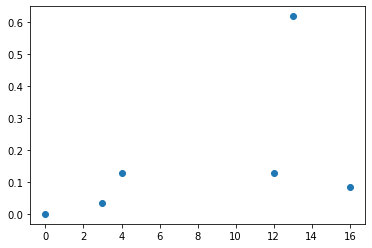

In [47]:
y = []
x = []
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])**2>=1e-4:
        y.append(np.abs(eigenvec[:,0][i])**2) 
        x.append(i)
plt.plot(x,y, "o")


In [48]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        sigma_e = rot_sigma(2*k,i,j,phi,theta)@sigma_e
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)):
        sigma_o = rot_sigma(2*k+1,i,j,phi,theta)@sigma_o
    return(sigma_o)

def rot_sigma_r(i,j,phi,theta):
    sigma_r = sparse.identity(basis.Ns,dtype = complex)
    sigma_r = rot_sigma(0,i,j,phi,theta)@rot_sigma(L-1,i,j,phi,theta)
    return(sigma_r)


def sigma(k,i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    if k==0:
        tensprod = sigma
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,sigma)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def sigma_e(i,j,phi):
    sigma_e = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_e = sparse.csc_matrix(sigma_e)
    for k in range(1,int(L/2)):
        sigma_e +=sigma(2*k,i,j,phi)
    return sigma_e

def sigma_o(i,j,phi):
    sigma_o = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_o = sparse.csc_matrix(sigma_o)
    for k in range(int(L/2)):
        sigma_o +=sigma(2*k+1,i,j,phi)
    return sigma_o

def sigma_r(i,j,phi):
    sigma_r = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_r = sparse.csc_matrix(sigma_r)
    sigma_r = sigma(0,i,j,phi)+sigma(L-1,i,j,phi)
    return sigma_r

In [67]:
def swap(m,n):
    swap_matrix = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    swap_matrix = sparse.csc_matrix(swap_matrix)
    for i in range(basis.Ns):
        state_m = basis.int_to_state(basis.Ns-i-1)[2*m+1]
        state_n = basis.int_to_state(basis.Ns-i-1)[2*n+1]
        string = list(basis.int_to_state(basis.Ns-i-1))
        string[2*m+1],string[2*n+1] = state_n,state_m
        string = "".join(string)
        string = string.replace(" ", "")
        string = string.replace("|","")
        string = string.replace(">", "")
        i_new = basis.Ns-1-basis.state_to_int(string)
        swap_matrix[i_new,i] = 1.
        
    return swap_matrix


def exp_gate(k,theta):
    Matrix = np.zeros((9,9),dtype = complex)
    Matrix = sparse.csc_matrix(Matrix)
    Matrix[8-0,8-0] = np.cos(theta/2)
    Matrix[8-1,8-1] = np.cos(theta/2)
    Matrix[8-2,8-2] = 0

    Matrix[8-3,8-3] = np.cos(theta/2)
    Matrix[8-4,8-4] = np.cos(theta/2)
    Matrix[8-5,8-5] = 0

    Matrix[8-6,8-6] = -np.cos(theta/2)
    Matrix[8-7,8-7] = np.cos(theta/2)
    Matrix[8-8,8-8] = -1j

    Matrix[8-0,8-4] = -1j*np.sin(theta/2)
    Matrix[8-4,8-0] = -1j*np.sin(theta/2)

    Matrix[8-1,8-3] = -1j*np.sin(theta/2)
    Matrix[8-3,8-1] = -1j*np.sin(theta/2)


    Matrix[8-5,8-2] = -1
    Matrix[8-2,8-5] = -1

    Matrix[8-6,8-7] = np.sin(theta/2)
    Matrix[8-7,8-6] = np.sin(theta/2)

    if k == 2:
        Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3))
    if k == 0:
        Matrix_full = scipy.sparse.kron(sparse.identity(3),Matrix)
    if k == 1:
        Matrix_full = swap(1,2)@scipy.sparse.kron(Matrix,sparse.identity(3))@swap(1,2)
    return Matrix_full






                
matrix_part = 1j*logm(exp_gate(0,1).toarray()@exp_gate(1,1).toarray()@exp_gate(2,1).toarray())
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    
    return exp_gate(0,theta)@exp_gate(1,theta)@exp_gate(2,theta)


In [68]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [78]:
def R(i,theta):
    
    if i%7 == 0:
        return(ms_gate_global(theta).toarray())
    

    
    if i%7 == 1:
        return(rot_sigma_o(0,1,0,theta).toarray())


    if i%7 == 2:
        return(rot_sigma_o(0,2,0,theta).toarray())

    
    if i%7 == 3:
        return(rot_sigma_o(1,2,np.pi/2,theta).toarray())

    if i%7 == 4:
        return(rot_sigma_r(0,1,0,theta).toarray())


    if i%7 == 5:
        return(rot_sigma_r(0,2,0,theta).toarray())

    
    if i%7 == 6:
        return(rot_sigma_r(1,2,np.pi/2,theta).toarray())
    
def S(i):
    
    if i%7 == 0:
        return(-1j*matrix_part)

    
     
    if i%7 == 1:
        return(-1j*sigma_o(0,1,0).toarray())

    
    if i%7 == 2:
        return(-1j*sigma_o(0,2,0).toarray())

    
    if i%7 == 3:
        return(-1j*sigma_o(1,2,np.pi/2).toarray())

     
    if i%7 == 4:
        return(-1j*sigma_r(0,1,0).toarray())

    
    if i%7 == 5:
        return(-1j*sigma_r(0,2,0).toarray())
    

    if i%7 == 6:
        return(-1j*sigma_r(1,2,np.pi/2).toarray())


In [79]:
coeff = 7
stepp = 1000
t_final = 10

In [80]:
matr = full_ham_matrix.toarray()
ones = np.ones(coeff*N)
ID = np.identity(coeff*N)
psi_0_conj = np.conj(psi_0)
A = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
B = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
dd = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]

In [81]:
def rhs(t,theta):
    
    print(datetime.datetime.now())
    for k in range(coeff*N):
        B[k] = R(k,theta[k])

    print("start",datetime.datetime.now())
    
    for k in range(coeff*N):
        
        B[k] = S(k)@R(k,theta[k])

        dd[k] = reduce(np.dot,B)

        B[k] = R(k,theta[k])
        
    print("stop_reduce",datetime.datetime.now())
    

    DD = np.array(dd)
    
    X = np.zeros((coeff*N,coeff*N),dtype = complex)
    Y = np.zeros(coeff*N,dtype = complex)

    BBB = reduce(np.dot,B)
    DD_d = np.einsum("kij->kji",DD.conj())
    BBB_dagger = BBB.conj().T

    
    
    psi_conj_d = np.einsum("m,imn->in",psi_0_conj,DD_d)
    psi_d = np.einsum("jnl,l->jn",DD,psi_0)
    
    psi_conj_b = np.einsum("m,mn->n",psi_0_conj,BBB_dagger)
    psi_b = np.einsum("lk,k->l",BBB,psi_0)

    X = np.einsum("in,jn->ij",psi_conj_d,psi_d)

    Y = np.einsum("il,ln,n->i",psi_conj_d,matr,psi_b)
    
    XX = np.einsum("il,l->i",psi_conj_d,psi_b)
    
    YY_1 = np.einsum("n,in->i",psi_conj_b,psi_d)
        
    YY_2 = np.einsum("i,ij,j",psi_conj_b,matr,psi_b)
    YY = YY_1*YY_2
    XX = np.outer(XX,XX)
    X_r = 2*np.real(X+XX)
    Y_i = 2*np.real(Y+YY)
    result = -np.linalg.pinv(X_r,rcond = 1e-6)@Y_i
    print(datetime.datetime.now())

    print(t)

    return result

In [82]:
time_domain = np.linspace(0, t_final, stepp)


In [83]:
# RK-4 method
def rk4(x0,y0,xn,n):
    global Y

    # Calculating step size
    h = (xn-x0)/n

    #print('\n--------SOLUTION--------')
    #print('-------------------------')    
    #print('x0\ty0\tyn')
    #print('-------------------------')
    for i in range(n):
        k1 = h * (rhs(x0, y0))
        k2 = h * (rhs((x0+h/2), (y0+k1/2)))
        k3 = h * (rhs((x0+h/2), (y0+k2/2)))
        k4 = h * (rhs((x0+h), (y0+k3)))
        k = (k1+2*k2+2*k3+k4)/6
        yn = y0 + k
        #print('%.4f\t%.4f\t%.4f'% (x0,y0,yn) )
        #print('-------------------------')
        y0 = yn
        x0 = x0+h
        Y.append(y0)
    
    #print('\nAt x=%.4f, y=%.4f' %(xn,yn))

# Inputs
#print('Enter initial conditions:')
#x0 = float(input('x0 = '))
#y0 = float(input('y0 = '))

#print('Enter calculation point: ')
#xn = float(input('xn = '))

#print('Enter number of steps:')
#step = int(input('Number of steps = '))

# RK4 method call


In [84]:
#start_point = 0.001*np.ones(coeff*N)
expt_value = []
energyy = []

for kkk in range(1):
    Y = []
    start_point = np.random.rand(coeff*N)
    rk4(0,start_point,t_final,stepp)
    def var_ansatz(theta,psi_0):
        psi = psi_0
        for i in range(coeff*N):
            psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi

        return psi
    psi = var_ansatz(start_point,psi_0)
    psi_ground = eigenvec[:,0]
    expt_value_u = np.zeros(len(time_domain))
    energy = np.zeros(len(time_domain))

    psi = var_ansatz(start_point,psi_0)
    for tt in range(len(time_domain)):
        theta = []
        for i in range(coeff*N):
            theta.append(Y[tt][i])

        psi_var = var_ansatz(theta,psi_0)
        for i in range(L+1):
            psi_var = (Proj[i]+Proj_0[i])@psi_var
        norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))

        expt_value_u[tt] = np.abs(np.conj(psi_var)@psi_ground/norm)**2
        energy[tt] = np.real(np.conj(psi_var)@full_ham_matrix@psi_var/norm**2)
        
    expt_value.append(expt_value_u)
    energyy.append(energy)


    

2022-08-09 18:25:07.889825
start 2022-08-09 18:25:07.937931
stop_reduce 2022-08-09 18:25:08.035220
2022-08-09 18:25:08.035835
0
2022-08-09 18:25:08.035996
start 2022-08-09 18:25:08.077764


/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


stop_reduce 2022-08-09 18:25:08.173631
2022-08-09 18:25:08.174399
0.005
2022-08-09 18:25:08.174447
start 2022-08-09 18:25:08.216396
stop_reduce 2022-08-09 18:25:08.306122
2022-08-09 18:25:08.306625
0.005
2022-08-09 18:25:08.306661
start 2022-08-09 18:25:08.348574
stop_reduce 2022-08-09 18:25:08.445710
2022-08-09 18:25:08.446466
0.01
2022-08-09 18:25:08.446520
start 2022-08-09 18:25:08.488546
stop_reduce 2022-08-09 18:25:08.578604
2022-08-09 18:25:08.579138
0.01
2022-08-09 18:25:08.579260
start 2022-08-09 18:25:08.621256
stop_reduce 2022-08-09 18:25:08.730825
2022-08-09 18:25:08.731574
0.015
2022-08-09 18:25:08.731628
start 2022-08-09 18:25:08.773671
stop_reduce 2022-08-09 18:25:08.863565
2022-08-09 18:25:08.864093
0.015
2022-08-09 18:25:08.864128
start 2022-08-09 18:25:08.906405
stop_reduce 2022-08-09 18:25:09.000229
2022-08-09 18:25:09.000981
0.02
2022-08-09 18:25:09.001177
start 2022-08-09 18:25:09.042910
stop_reduce 2022-08-09 18:25:09.135194
2022-08-09 18:25:09.135874
0.02
2022-08-

stop_reduce 2022-08-09 18:25:16.675420
2022-08-09 18:25:16.676080
0.155
2022-08-09 18:25:16.676147
start 2022-08-09 18:25:16.721172
stop_reduce 2022-08-09 18:25:16.815169
2022-08-09 18:25:16.815777
0.155
2022-08-09 18:25:16.815842
start 2022-08-09 18:25:16.861152
stop_reduce 2022-08-09 18:25:16.965182
2022-08-09 18:25:16.965868
0.16
2022-08-09 18:25:16.965947
start 2022-08-09 18:25:17.013709
stop_reduce 2022-08-09 18:25:17.113608
2022-08-09 18:25:17.114978
0.16
2022-08-09 18:25:17.115059
start 2022-08-09 18:25:17.161194
stop_reduce 2022-08-09 18:25:17.255666
2022-08-09 18:25:17.256317
0.165
2022-08-09 18:25:17.256381
start 2022-08-09 18:25:17.299056
stop_reduce 2022-08-09 18:25:17.390328
2022-08-09 18:25:17.390784
0.165
2022-08-09 18:25:17.390827
start 2022-08-09 18:25:17.433667
stop_reduce 2022-08-09 18:25:17.527802
2022-08-09 18:25:17.528520
0.17
2022-08-09 18:25:17.528576
start 2022-08-09 18:25:17.571332
stop_reduce 2022-08-09 18:25:17.668278
2022-08-09 18:25:17.669711
0.17
2022-08-

stop_reduce 2022-08-09 18:25:25.069681
2022-08-09 18:25:25.070320
0.3000000000000001
2022-08-09 18:25:25.070368
start 2022-08-09 18:25:25.113970
stop_reduce 2022-08-09 18:25:25.207108
2022-08-09 18:25:25.207692
0.3000000000000001
2022-08-09 18:25:25.207733
start 2022-08-09 18:25:25.255269
stop_reduce 2022-08-09 18:25:25.351102
2022-08-09 18:25:25.351688
0.3050000000000001
2022-08-09 18:25:25.351749
start 2022-08-09 18:25:25.396899
stop_reduce 2022-08-09 18:25:25.489345
2022-08-09 18:25:25.489913
0.3050000000000001
2022-08-09 18:25:25.489976
start 2022-08-09 18:25:25.532641
stop_reduce 2022-08-09 18:25:25.624542
2022-08-09 18:25:25.625080
0.3100000000000001
2022-08-09 18:25:25.625131
start 2022-08-09 18:25:25.667909
stop_reduce 2022-08-09 18:25:25.761169
2022-08-09 18:25:25.761616
0.3100000000000001
2022-08-09 18:25:25.761664
start 2022-08-09 18:25:25.811001
stop_reduce 2022-08-09 18:25:25.903079
2022-08-09 18:25:25.903653
0.3150000000000001
2022-08-09 18:25:25.903706
start 2022-08-09 1

stop_reduce 2022-08-09 18:25:33.053607
2022-08-09 18:25:33.054232
0.44500000000000023
2022-08-09 18:25:33.054350
start 2022-08-09 18:25:33.100694
stop_reduce 2022-08-09 18:25:33.200028
2022-08-09 18:25:33.200670
0.44500000000000023
2022-08-09 18:25:33.200726
start 2022-08-09 18:25:33.248305
stop_reduce 2022-08-09 18:25:33.354476
2022-08-09 18:25:33.355281
0.45000000000000023
2022-08-09 18:25:33.355341
start 2022-08-09 18:25:33.404357
stop_reduce 2022-08-09 18:25:33.509073
2022-08-09 18:25:33.509655
0.45000000000000023
2022-08-09 18:25:33.509699
start 2022-08-09 18:25:33.559198
stop_reduce 2022-08-09 18:25:33.664308
2022-08-09 18:25:33.664856
0.45500000000000024
2022-08-09 18:25:33.664911
start 2022-08-09 18:25:33.715153
stop_reduce 2022-08-09 18:25:33.827444
2022-08-09 18:25:33.828164
0.45500000000000024
2022-08-09 18:25:33.828230
start 2022-08-09 18:25:33.879170
stop_reduce 2022-08-09 18:25:33.988466
2022-08-09 18:25:33.989069
0.46000000000000024
2022-08-09 18:25:33.989122
start 2022-

start 2022-08-09 18:25:42.517027
stop_reduce 2022-08-09 18:25:42.622229
2022-08-09 18:25:42.622773
0.5900000000000003
2022-08-09 18:25:42.622822
start 2022-08-09 18:25:42.673371
stop_reduce 2022-08-09 18:25:42.783581
2022-08-09 18:25:42.784352
0.5900000000000003
2022-08-09 18:25:42.784404
start 2022-08-09 18:25:42.836682
stop_reduce 2022-08-09 18:25:42.944544
2022-08-09 18:25:42.945165
0.5950000000000003
2022-08-09 18:25:42.945214
start 2022-08-09 18:25:42.996204
stop_reduce 2022-08-09 18:25:43.104286
2022-08-09 18:25:43.104930
0.5950000000000003
2022-08-09 18:25:43.104979
start 2022-08-09 18:25:43.155737
stop_reduce 2022-08-09 18:25:43.266047
2022-08-09 18:25:43.266792
0.6000000000000003
2022-08-09 18:25:43.266853
start 2022-08-09 18:25:43.317316
stop_reduce 2022-08-09 18:25:43.426145
2022-08-09 18:25:43.426795
0.6000000000000003
2022-08-09 18:25:43.426845
start 2022-08-09 18:25:43.477977
stop_reduce 2022-08-09 18:25:43.586163
2022-08-09 18:25:43.586843
0.6050000000000003
2022-08-09 1

start 2022-08-09 18:25:51.608475
stop_reduce 2022-08-09 18:25:51.715141
2022-08-09 18:25:51.715923
0.7300000000000004
2022-08-09 18:25:51.715981
start 2022-08-09 18:25:51.765301
stop_reduce 2022-08-09 18:25:51.871198
2022-08-09 18:25:51.871966
0.7350000000000004
2022-08-09 18:25:51.872014
start 2022-08-09 18:25:51.920892
stop_reduce 2022-08-09 18:25:52.032942
2022-08-09 18:25:52.033487
0.7350000000000004
2022-08-09 18:25:52.033663
start 2022-08-09 18:25:52.082260
stop_reduce 2022-08-09 18:25:52.185025
2022-08-09 18:25:52.185683
0.7400000000000004
2022-08-09 18:25:52.185860
start 2022-08-09 18:25:52.235596
stop_reduce 2022-08-09 18:25:52.341227
2022-08-09 18:25:52.341893
0.7400000000000004
2022-08-09 18:25:52.341941
start 2022-08-09 18:25:52.390991
stop_reduce 2022-08-09 18:25:52.496118
2022-08-09 18:25:52.496965
0.7450000000000004
2022-08-09 18:25:52.497025
start 2022-08-09 18:25:52.557116
stop_reduce 2022-08-09 18:25:52.678916
2022-08-09 18:25:52.679717
0.7450000000000004
2022-08-09 1

stop_reduce 2022-08-09 18:26:00.682335
2022-08-09 18:26:00.683294
0.8750000000000006
2022-08-09 18:26:00.683367
start 2022-08-09 18:26:00.737120
stop_reduce 2022-08-09 18:26:00.842262
2022-08-09 18:26:00.842936
0.8750000000000006
2022-08-09 18:26:00.842984
start 2022-08-09 18:26:00.892516
stop_reduce 2022-08-09 18:26:00.997296
2022-08-09 18:26:00.997825
0.8800000000000006
2022-08-09 18:26:00.997883
start 2022-08-09 18:26:01.046945
stop_reduce 2022-08-09 18:26:01.159441
2022-08-09 18:26:01.160044
0.8800000000000006
2022-08-09 18:26:01.160096
start 2022-08-09 18:26:01.209080
stop_reduce 2022-08-09 18:26:01.314001
2022-08-09 18:26:01.314638
0.8850000000000006
2022-08-09 18:26:01.314702
start 2022-08-09 18:26:01.364266
stop_reduce 2022-08-09 18:26:01.468922
2022-08-09 18:26:01.469478
0.8850000000000006
2022-08-09 18:26:01.469531
start 2022-08-09 18:26:01.518588
stop_reduce 2022-08-09 18:26:01.621670
2022-08-09 18:26:01.622290
0.8900000000000006
2022-08-09 18:26:01.622424
start 2022-08-09 1

stop_reduce 2022-08-09 18:26:09.585543
2022-08-09 18:26:09.586182
1.0150000000000006
2022-08-09 18:26:09.586223
start 2022-08-09 18:26:09.634880
stop_reduce 2022-08-09 18:26:09.740032
2022-08-09 18:26:09.740773
1.0200000000000007
2022-08-09 18:26:09.740842
start 2022-08-09 18:26:09.790919
stop_reduce 2022-08-09 18:26:09.895796
2022-08-09 18:26:09.896381
1.0200000000000007
2022-08-09 18:26:09.896440
start 2022-08-09 18:26:09.945232
stop_reduce 2022-08-09 18:26:10.050143
2022-08-09 18:26:10.050743
1.0250000000000006
2022-08-09 18:26:10.050796
start 2022-08-09 18:26:10.099455
stop_reduce 2022-08-09 18:26:10.203673
2022-08-09 18:26:10.204327
1.0250000000000006
2022-08-09 18:26:10.204378
start 2022-08-09 18:26:10.257340
stop_reduce 2022-08-09 18:26:10.361427
2022-08-09 18:26:10.362088
1.0300000000000007
2022-08-09 18:26:10.362142
start 2022-08-09 18:26:10.410798
stop_reduce 2022-08-09 18:26:10.515704
2022-08-09 18:26:10.516358
1.0300000000000007
2022-08-09 18:26:10.516404
start 2022-08-09 1

stop_reduce 2022-08-09 18:26:18.426386
2022-08-09 18:26:18.427014
1.1600000000000008
2022-08-09 18:26:18.427074
start 2022-08-09 18:26:18.475553
stop_reduce 2022-08-09 18:26:18.579054
2022-08-09 18:26:18.579561
1.1600000000000008
2022-08-09 18:26:18.579615
start 2022-08-09 18:26:18.628817
stop_reduce 2022-08-09 18:26:18.735371
2022-08-09 18:26:18.736096
1.1650000000000007
2022-08-09 18:26:18.736167
start 2022-08-09 18:26:18.786152
stop_reduce 2022-08-09 18:26:18.893501
2022-08-09 18:26:18.894198
1.1650000000000007
2022-08-09 18:26:18.894245
start 2022-08-09 18:26:18.942742
stop_reduce 2022-08-09 18:26:19.045939
2022-08-09 18:26:19.046525
1.1700000000000008
2022-08-09 18:26:19.046670
start 2022-08-09 18:26:19.095651
stop_reduce 2022-08-09 18:26:19.199332
2022-08-09 18:26:19.199901
1.1700000000000008
2022-08-09 18:26:19.199945
start 2022-08-09 18:26:19.249946
stop_reduce 2022-08-09 18:26:19.355114
2022-08-09 18:26:19.355750
1.1750000000000007
2022-08-09 18:26:19.355811
start 2022-08-09 1

stop_reduce 2022-08-09 18:26:27.337605
2022-08-09 18:26:27.338299
1.300000000000001
2022-08-09 18:26:27.338470
start 2022-08-09 18:26:27.386839
stop_reduce 2022-08-09 18:26:27.491959
2022-08-09 18:26:27.492675
1.3050000000000008
2022-08-09 18:26:27.492729
start 2022-08-09 18:26:27.542408
stop_reduce 2022-08-09 18:26:27.647856
2022-08-09 18:26:27.648407
1.3050000000000008
2022-08-09 18:26:27.648460
start 2022-08-09 18:26:27.697686
stop_reduce 2022-08-09 18:26:27.803445
2022-08-09 18:26:27.804143
1.310000000000001
2022-08-09 18:26:27.804198
start 2022-08-09 18:26:27.852939
stop_reduce 2022-08-09 18:26:27.956801
2022-08-09 18:26:27.957379
1.310000000000001
2022-08-09 18:26:27.957425
start 2022-08-09 18:26:28.007071
stop_reduce 2022-08-09 18:26:28.110930
2022-08-09 18:26:28.111492
1.3150000000000008
2022-08-09 18:26:28.111538
start 2022-08-09 18:26:28.159929
stop_reduce 2022-08-09 18:26:28.266339
2022-08-09 18:26:28.267177
1.3150000000000008
2022-08-09 18:26:28.267233
start 2022-08-09 18:2

stop_reduce 2022-08-09 18:26:36.386313
2022-08-09 18:26:36.386911
1.445000000000001
2022-08-09 18:26:36.386968
start 2022-08-09 18:26:36.436815
stop_reduce 2022-08-09 18:26:36.542574
2022-08-09 18:26:36.543078
1.445000000000001
2022-08-09 18:26:36.543128
start 2022-08-09 18:26:36.591999
stop_reduce 2022-08-09 18:26:36.697065
2022-08-09 18:26:36.697752
1.450000000000001
2022-08-09 18:26:36.697834
start 2022-08-09 18:26:36.749444
stop_reduce 2022-08-09 18:26:36.857086
2022-08-09 18:26:36.857847
1.450000000000001
2022-08-09 18:26:36.857902
start 2022-08-09 18:26:36.907724
stop_reduce 2022-08-09 18:26:37.014075
2022-08-09 18:26:37.014661
1.455000000000001
2022-08-09 18:26:37.014706
start 2022-08-09 18:26:37.064905
stop_reduce 2022-08-09 18:26:37.171423
2022-08-09 18:26:37.171951
1.455000000000001
2022-08-09 18:26:37.172002
start 2022-08-09 18:26:37.220802
stop_reduce 2022-08-09 18:26:37.330402
2022-08-09 18:26:37.331090
1.460000000000001
2022-08-09 18:26:37.331156
start 2022-08-09 18:26:37

stop_reduce 2022-08-09 18:26:45.303957
2022-08-09 18:26:45.304634
1.585000000000001
2022-08-09 18:26:45.304691
start 2022-08-09 18:26:45.353482
stop_reduce 2022-08-09 18:26:45.457256
2022-08-09 18:26:45.457823
1.5900000000000012
2022-08-09 18:26:45.457882
start 2022-08-09 18:26:45.506930
stop_reduce 2022-08-09 18:26:45.610286
2022-08-09 18:26:45.610820
1.5900000000000012
2022-08-09 18:26:45.610872
start 2022-08-09 18:26:45.661799
stop_reduce 2022-08-09 18:26:45.770416
2022-08-09 18:26:45.771194
1.595000000000001
2022-08-09 18:26:45.771247
start 2022-08-09 18:26:45.821605
stop_reduce 2022-08-09 18:26:45.927731
2022-08-09 18:26:45.928309
1.595000000000001
2022-08-09 18:26:45.928356
start 2022-08-09 18:26:45.978574
stop_reduce 2022-08-09 18:26:46.084820
2022-08-09 18:26:46.085444
1.6000000000000012
2022-08-09 18:26:46.085580
start 2022-08-09 18:26:46.133778
stop_reduce 2022-08-09 18:26:46.237532
2022-08-09 18:26:46.238161
1.6000000000000012
2022-08-09 18:26:46.238223
start 2022-08-09 18:2

stop_reduce 2022-08-09 18:26:54.162220
2022-08-09 18:26:54.162785
1.7300000000000013
2022-08-09 18:26:54.162842
start 2022-08-09 18:26:54.212417
stop_reduce 2022-08-09 18:26:54.316326
2022-08-09 18:26:54.316953
1.7300000000000013
2022-08-09 18:26:54.317011
start 2022-08-09 18:26:54.365945
stop_reduce 2022-08-09 18:26:54.469532
2022-08-09 18:26:54.470081
1.7350000000000012
2022-08-09 18:26:54.470137
start 2022-08-09 18:26:54.518437
stop_reduce 2022-08-09 18:26:54.622138
2022-08-09 18:26:54.622706
1.7350000000000012
2022-08-09 18:26:54.622758
start 2022-08-09 18:26:54.671518
stop_reduce 2022-08-09 18:26:54.780629
2022-08-09 18:26:54.781314
1.7400000000000013
2022-08-09 18:26:54.781397
start 2022-08-09 18:26:54.832422
stop_reduce 2022-08-09 18:26:54.938650
2022-08-09 18:26:54.939223
1.7400000000000013
2022-08-09 18:26:54.939279
start 2022-08-09 18:26:54.988980
stop_reduce 2022-08-09 18:26:55.095806
2022-08-09 18:26:55.096387
1.7450000000000012
2022-08-09 18:26:55.096527
start 2022-08-09 1

stop_reduce 2022-08-09 18:27:03.092328
2022-08-09 18:27:03.093003
1.8700000000000014
2022-08-09 18:27:03.093087
start 2022-08-09 18:27:03.142010
stop_reduce 2022-08-09 18:27:03.248783
2022-08-09 18:27:03.249535
1.8750000000000013
2022-08-09 18:27:03.249591
start 2022-08-09 18:27:03.299258
stop_reduce 2022-08-09 18:27:03.404026
2022-08-09 18:27:03.404617
1.8750000000000013
2022-08-09 18:27:03.404661
start 2022-08-09 18:27:03.453516
stop_reduce 2022-08-09 18:27:03.559115
2022-08-09 18:27:03.559764
1.8800000000000014
2022-08-09 18:27:03.559972
start 2022-08-09 18:27:03.608950
stop_reduce 2022-08-09 18:27:03.713633
2022-08-09 18:27:03.714223
1.8800000000000014
2022-08-09 18:27:03.714270
start 2022-08-09 18:27:03.765780
stop_reduce 2022-08-09 18:27:03.878563
2022-08-09 18:27:03.879151
1.8850000000000013
2022-08-09 18:27:03.879209
start 2022-08-09 18:27:03.928392
stop_reduce 2022-08-09 18:27:04.033850
2022-08-09 18:27:04.034421
1.8850000000000013
2022-08-09 18:27:04.034470
start 2022-08-09 1

start 2022-08-09 18:27:12.216248
stop_reduce 2022-08-09 18:27:12.325453
2022-08-09 18:27:12.326232
2.015000000000001
2022-08-09 18:27:12.326283
start 2022-08-09 18:27:12.376797
stop_reduce 2022-08-09 18:27:12.485073
2022-08-09 18:27:12.485727
2.020000000000001
2022-08-09 18:27:12.485779
start 2022-08-09 18:27:12.536195
stop_reduce 2022-08-09 18:27:12.643495
2022-08-09 18:27:12.644095
2.020000000000001
2022-08-09 18:27:12.644144
start 2022-08-09 18:27:12.695295
stop_reduce 2022-08-09 18:27:12.805649
2022-08-09 18:27:12.806467
2.025000000000001
2022-08-09 18:27:12.806521
start 2022-08-09 18:27:12.857276
stop_reduce 2022-08-09 18:27:12.966175
2022-08-09 18:27:12.966896
2.025000000000001
2022-08-09 18:27:12.966941
start 2022-08-09 18:27:13.017775
stop_reduce 2022-08-09 18:27:13.126082
2022-08-09 18:27:13.126620
2.0300000000000007
2022-08-09 18:27:13.126669
start 2022-08-09 18:27:13.177769
stop_reduce 2022-08-09 18:27:13.286897
2022-08-09 18:27:13.287629
2.0300000000000007
2022-08-09 18:27:

stop_reduce 2022-08-09 18:27:22.511205
2022-08-09 18:27:22.512095
2.159999999999998
2022-08-09 18:27:22.512157
start 2022-08-09 18:27:22.570470
stop_reduce 2022-08-09 18:27:22.697252
2022-08-09 18:27:22.698081
2.164999999999998
2022-08-09 18:27:22.698263
start 2022-08-09 18:27:22.755453
stop_reduce 2022-08-09 18:27:22.874023
2022-08-09 18:27:22.874663
2.164999999999998
2022-08-09 18:27:22.874713
start 2022-08-09 18:27:22.929011
stop_reduce 2022-08-09 18:27:23.049512
2022-08-09 18:27:23.050365
2.1699999999999977
2022-08-09 18:27:23.050428
start 2022-08-09 18:27:23.112292
stop_reduce 2022-08-09 18:27:23.224600
2022-08-09 18:27:23.225306
2.1699999999999977
2022-08-09 18:27:23.225357
start 2022-08-09 18:27:23.278883
stop_reduce 2022-08-09 18:27:23.391996
2022-08-09 18:27:23.392594
2.1749999999999976
2022-08-09 18:27:23.392641
start 2022-08-09 18:27:23.444855
stop_reduce 2022-08-09 18:27:23.556278
2022-08-09 18:27:23.557172
2.1749999999999976
2022-08-09 18:27:23.557226
start 2022-08-09 18:2

stop_reduce 2022-08-09 18:27:31.857948
2022-08-09 18:27:31.858851
2.304999999999995
2022-08-09 18:27:31.858932
start 2022-08-09 18:27:31.927099
stop_reduce 2022-08-09 18:27:32.065814
2022-08-09 18:27:32.066553
2.304999999999995
2022-08-09 18:27:32.066620
start 2022-08-09 18:27:32.131700
stop_reduce 2022-08-09 18:27:32.281882
2022-08-09 18:27:32.282678
2.3099999999999947
2022-08-09 18:27:32.282762
start 2022-08-09 18:27:32.349496
stop_reduce 2022-08-09 18:27:32.476026
2022-08-09 18:27:32.476745
2.3099999999999947
2022-08-09 18:27:32.476822
start 2022-08-09 18:27:32.537615
stop_reduce 2022-08-09 18:27:32.683039
2022-08-09 18:27:32.684588
2.3149999999999946
2022-08-09 18:27:32.684665
start 2022-08-09 18:27:32.749082
stop_reduce 2022-08-09 18:27:32.885263
2022-08-09 18:27:32.886087
2.3149999999999946
2022-08-09 18:27:32.886148
start 2022-08-09 18:27:32.946645
stop_reduce 2022-08-09 18:27:33.076048
2022-08-09 18:27:33.076844
2.3199999999999945
2022-08-09 18:27:33.076917
start 2022-08-09 18:

start 2022-08-09 18:27:42.647380
stop_reduce 2022-08-09 18:27:42.755450
2022-08-09 18:27:42.756068
2.4499999999999917
2022-08-09 18:27:42.756120
start 2022-08-09 18:27:42.806427
stop_reduce 2022-08-09 18:27:42.919192
2022-08-09 18:27:42.920037
2.4499999999999917
2022-08-09 18:27:42.920090
start 2022-08-09 18:27:42.972463
stop_reduce 2022-08-09 18:27:43.088432
2022-08-09 18:27:43.089214
2.4549999999999916
2022-08-09 18:27:43.089271
start 2022-08-09 18:27:43.144140
stop_reduce 2022-08-09 18:27:43.252536
2022-08-09 18:27:43.253177
2.4549999999999916
2022-08-09 18:27:43.253226
start 2022-08-09 18:27:43.303690
stop_reduce 2022-08-09 18:27:43.413398
2022-08-09 18:27:43.414065
2.4599999999999915
2022-08-09 18:27:43.414234
start 2022-08-09 18:27:43.467267
stop_reduce 2022-08-09 18:27:43.584745
2022-08-09 18:27:43.585533
2.4599999999999915
2022-08-09 18:27:43.585734
start 2022-08-09 18:27:43.642301
stop_reduce 2022-08-09 18:27:43.753367
2022-08-09 18:27:43.754043
2.4649999999999914
2022-08-09 1

start 2022-08-09 18:27:51.849992
stop_reduce 2022-08-09 18:27:51.957894
2022-08-09 18:27:51.958393
2.5899999999999888
2022-08-09 18:27:51.958446
start 2022-08-09 18:27:52.008684
stop_reduce 2022-08-09 18:27:52.118582
2022-08-09 18:27:52.119292
2.5949999999999886
2022-08-09 18:27:52.119363
start 2022-08-09 18:27:52.170047
stop_reduce 2022-08-09 18:27:52.278249
2022-08-09 18:27:52.278779
2.5949999999999886
2022-08-09 18:27:52.278829
start 2022-08-09 18:27:52.329417
stop_reduce 2022-08-09 18:27:52.434606
2022-08-09 18:27:52.435132
2.5999999999999885
2022-08-09 18:27:52.435189
start 2022-08-09 18:27:52.484367
stop_reduce 2022-08-09 18:27:52.592913
2022-08-09 18:27:52.593636
2.5999999999999885
2022-08-09 18:27:52.593712
start 2022-08-09 18:27:52.644884
stop_reduce 2022-08-09 18:27:52.753387
2022-08-09 18:27:52.754141
2.6049999999999884
2022-08-09 18:27:52.754312
start 2022-08-09 18:27:52.806104
stop_reduce 2022-08-09 18:27:52.916690
2022-08-09 18:27:52.917254
2.6049999999999884
2022-08-09 1

start 2022-08-09 18:28:01.395715
stop_reduce 2022-08-09 18:28:01.506240
2022-08-09 18:28:01.507050
2.7349999999999857
2022-08-09 18:28:01.507100
start 2022-08-09 18:28:01.561066
stop_reduce 2022-08-09 18:28:01.674376
2022-08-09 18:28:01.675069
2.7399999999999856
2022-08-09 18:28:01.675135
start 2022-08-09 18:28:01.730929
stop_reduce 2022-08-09 18:28:01.844854
2022-08-09 18:28:01.845525
2.7399999999999856
2022-08-09 18:28:01.845594
start 2022-08-09 18:28:01.898677
stop_reduce 2022-08-09 18:28:02.010169
2022-08-09 18:28:02.010753
2.7449999999999855
2022-08-09 18:28:02.010812
start 2022-08-09 18:28:02.063111
stop_reduce 2022-08-09 18:28:02.172215
2022-08-09 18:28:02.172870
2.7449999999999855
2022-08-09 18:28:02.172916
start 2022-08-09 18:28:02.226286
stop_reduce 2022-08-09 18:28:02.335940
2022-08-09 18:28:02.336618
2.7499999999999853
2022-08-09 18:28:02.336682
start 2022-08-09 18:28:02.388366
stop_reduce 2022-08-09 18:28:02.498001
2022-08-09 18:28:02.498629
2.7499999999999853
2022-08-09 1

start 2022-08-09 18:28:11.599817
stop_reduce 2022-08-09 18:28:11.715900
2022-08-09 18:28:11.716625
2.8799999999999826
2022-08-09 18:28:11.716682
start 2022-08-09 18:28:11.772248
stop_reduce 2022-08-09 18:28:11.899567
2022-08-09 18:28:11.900316
2.8849999999999825
2022-08-09 18:28:11.900376
start 2022-08-09 18:28:11.954319
stop_reduce 2022-08-09 18:28:12.067411
2022-08-09 18:28:12.067992
2.8849999999999825
2022-08-09 18:28:12.068039
start 2022-08-09 18:28:12.121761
stop_reduce 2022-08-09 18:28:12.236879
2022-08-09 18:28:12.237663
2.8899999999999824
2022-08-09 18:28:12.237733
start 2022-08-09 18:28:12.291946
stop_reduce 2022-08-09 18:28:12.411306
2022-08-09 18:28:12.412051
2.8899999999999824
2022-08-09 18:28:12.412128
start 2022-08-09 18:28:12.475713
stop_reduce 2022-08-09 18:28:12.600043
2022-08-09 18:28:12.600839
2.8949999999999823
2022-08-09 18:28:12.600900
start 2022-08-09 18:28:12.655471
stop_reduce 2022-08-09 18:28:12.778440
2022-08-09 18:28:12.779410
2.8949999999999823
2022-08-09 1

start 2022-08-09 18:28:21.779918
stop_reduce 2022-08-09 18:28:21.886568
2022-08-09 18:28:21.887154
3.0249999999999795
2022-08-09 18:28:21.887343
start 2022-08-09 18:28:21.937319
stop_reduce 2022-08-09 18:28:22.044440
2022-08-09 18:28:22.045096
3.0249999999999795
2022-08-09 18:28:22.045141
start 2022-08-09 18:28:22.095601
stop_reduce 2022-08-09 18:28:22.204756
2022-08-09 18:28:22.205602
3.0299999999999794
2022-08-09 18:28:22.205661
start 2022-08-09 18:28:22.257675
stop_reduce 2022-08-09 18:28:22.379977
2022-08-09 18:28:22.380658
3.0299999999999794
2022-08-09 18:28:22.380706
start 2022-08-09 18:28:22.442356
stop_reduce 2022-08-09 18:28:22.570392
2022-08-09 18:28:22.571117
3.0349999999999793
2022-08-09 18:28:22.571173
start 2022-08-09 18:28:22.630197
stop_reduce 2022-08-09 18:28:22.754971
2022-08-09 18:28:22.755558
3.0349999999999793
2022-08-09 18:28:22.755603
start 2022-08-09 18:28:22.820111
stop_reduce 2022-08-09 18:28:22.945267
2022-08-09 18:28:22.946102
3.039999999999979
2022-08-09 18

stop_reduce 2022-08-09 18:28:32.294386
2022-08-09 18:28:32.295745
3.1649999999999765
2022-08-09 18:28:32.295805
start 2022-08-09 18:28:32.350510
stop_reduce 2022-08-09 18:28:32.463929
2022-08-09 18:28:32.464545
3.1699999999999764
2022-08-09 18:28:32.464612
start 2022-08-09 18:28:32.519408
stop_reduce 2022-08-09 18:28:32.635360
2022-08-09 18:28:32.636884
3.1699999999999764
2022-08-09 18:28:32.636962
start 2022-08-09 18:28:32.712395
stop_reduce 2022-08-09 18:28:32.825012
2022-08-09 18:28:32.825742
3.1749999999999763
2022-08-09 18:28:32.825796
start 2022-08-09 18:28:32.878780
stop_reduce 2022-08-09 18:28:32.994752
2022-08-09 18:28:32.995372
3.1749999999999763
2022-08-09 18:28:32.995554
start 2022-08-09 18:28:33.048984
stop_reduce 2022-08-09 18:28:33.162723
2022-08-09 18:28:33.163362
3.179999999999976
2022-08-09 18:28:33.163427
start 2022-08-09 18:28:33.218409
stop_reduce 2022-08-09 18:28:33.334538
2022-08-09 18:28:33.335198
3.179999999999976
2022-08-09 18:28:33.335260
start 2022-08-09 18:

start 2022-08-09 18:28:42.242549
stop_reduce 2022-08-09 18:28:42.352499
2022-08-09 18:28:42.353118
3.3099999999999734
2022-08-09 18:28:42.353168
start 2022-08-09 18:28:42.408113
stop_reduce 2022-08-09 18:28:42.525866
2022-08-09 18:28:42.526607
3.3149999999999733
2022-08-09 18:28:42.526661
start 2022-08-09 18:28:42.580845
stop_reduce 2022-08-09 18:28:42.697227
2022-08-09 18:28:42.697925
3.3149999999999733
2022-08-09 18:28:42.697976
start 2022-08-09 18:28:42.751965
stop_reduce 2022-08-09 18:28:42.873247
2022-08-09 18:28:42.873968
3.319999999999973
2022-08-09 18:28:42.874035
start 2022-08-09 18:28:42.936460
stop_reduce 2022-08-09 18:28:43.072146
2022-08-09 18:28:43.073065
3.319999999999973
2022-08-09 18:28:43.073129
start 2022-08-09 18:28:43.132770
stop_reduce 2022-08-09 18:28:43.255202
2022-08-09 18:28:43.255862
3.324999999999973
2022-08-09 18:28:43.255915
start 2022-08-09 18:28:43.313121
stop_reduce 2022-08-09 18:28:43.431563
2022-08-09 18:28:43.432202
3.324999999999973
2022-08-09 18:28

start 2022-08-09 18:28:51.956074
stop_reduce 2022-08-09 18:28:52.098984
2022-08-09 18:28:52.099731
3.4549999999999703
2022-08-09 18:28:52.099811
start 2022-08-09 18:28:52.160400
stop_reduce 2022-08-09 18:28:52.302809
2022-08-09 18:28:52.303540
3.45999999999997
2022-08-09 18:28:52.303605
start 2022-08-09 18:28:52.364054
stop_reduce 2022-08-09 18:28:52.506449
2022-08-09 18:28:52.507439
3.45999999999997
2022-08-09 18:28:52.507529
start 2022-08-09 18:28:52.574047
stop_reduce 2022-08-09 18:28:52.725538
2022-08-09 18:28:52.726457
3.46499999999997
2022-08-09 18:28:52.726523
start 2022-08-09 18:28:52.798261
stop_reduce 2022-08-09 18:28:52.932993
2022-08-09 18:28:52.933802
3.46499999999997
2022-08-09 18:28:52.933861
start 2022-08-09 18:28:52.993698
stop_reduce 2022-08-09 18:28:53.125167
2022-08-09 18:28:53.126080
3.46999999999997
2022-08-09 18:28:53.126147
start 2022-08-09 18:28:53.196656
stop_reduce 2022-08-09 18:28:53.322311
2022-08-09 18:28:53.323099
3.46999999999997
2022-08-09 18:28:53.3231

start 2022-08-09 18:29:01.875522
stop_reduce 2022-08-09 18:29:01.981893
2022-08-09 18:29:01.982428
3.5999999999999672
2022-08-09 18:29:01.982485
start 2022-08-09 18:29:02.037545
stop_reduce 2022-08-09 18:29:02.144597
2022-08-09 18:29:02.145530
3.604999999999967
2022-08-09 18:29:02.145583
start 2022-08-09 18:29:02.195832
stop_reduce 2022-08-09 18:29:02.302096
2022-08-09 18:29:02.302693
3.604999999999967
2022-08-09 18:29:02.302739
start 2022-08-09 18:29:02.354183
stop_reduce 2022-08-09 18:29:02.460873
2022-08-09 18:29:02.461454
3.609999999999967
2022-08-09 18:29:02.461504
start 2022-08-09 18:29:02.511031
stop_reduce 2022-08-09 18:29:02.616681
2022-08-09 18:29:02.617319
3.609999999999967
2022-08-09 18:29:02.617365
start 2022-08-09 18:29:02.667111
stop_reduce 2022-08-09 18:29:02.777010
2022-08-09 18:29:02.777666
3.614999999999967
2022-08-09 18:29:02.777735
start 2022-08-09 18:29:02.829271
stop_reduce 2022-08-09 18:29:02.937611
2022-08-09 18:29:02.938266
3.614999999999967
2022-08-09 18:29:0

start 2022-08-09 18:29:12.532350
stop_reduce 2022-08-09 18:29:12.644455
2022-08-09 18:29:12.645026
3.744999999999964
2022-08-09 18:29:12.645081
start 2022-08-09 18:29:12.697688
stop_reduce 2022-08-09 18:29:12.815317
2022-08-09 18:29:12.816064
3.749999999999964
2022-08-09 18:29:12.816143
start 2022-08-09 18:29:12.870505
stop_reduce 2022-08-09 18:29:12.982877
2022-08-09 18:29:12.983484
3.749999999999964
2022-08-09 18:29:12.983543
start 2022-08-09 18:29:13.036828
stop_reduce 2022-08-09 18:29:13.160440
2022-08-09 18:29:13.161208
3.754999999999964
2022-08-09 18:29:13.161290
start 2022-08-09 18:29:13.246369
stop_reduce 2022-08-09 18:29:13.391826
2022-08-09 18:29:13.392645
3.754999999999964
2022-08-09 18:29:13.392704
start 2022-08-09 18:29:13.453975
stop_reduce 2022-08-09 18:29:13.575768
2022-08-09 18:29:13.576558
3.759999999999964
2022-08-09 18:29:13.576623
start 2022-08-09 18:29:13.633240
stop_reduce 2022-08-09 18:29:13.756991
2022-08-09 18:29:13.757745
3.759999999999964
2022-08-09 18:29:13

stop_reduce 2022-08-09 18:29:22.293603
2022-08-09 18:29:22.294202
3.889999999999961
2022-08-09 18:29:22.294264
start 2022-08-09 18:29:22.348118
stop_reduce 2022-08-09 18:29:22.459141
2022-08-09 18:29:22.459840
3.889999999999961
2022-08-09 18:29:22.459898
start 2022-08-09 18:29:22.513017
stop_reduce 2022-08-09 18:29:22.626706
2022-08-09 18:29:22.627340
3.894999999999961
2022-08-09 18:29:22.627390
start 2022-08-09 18:29:22.684324
stop_reduce 2022-08-09 18:29:22.821465
2022-08-09 18:29:22.822316
3.894999999999961
2022-08-09 18:29:22.822373
start 2022-08-09 18:29:22.878481
stop_reduce 2022-08-09 18:29:22.993463
2022-08-09 18:29:22.994153
3.899999999999961
2022-08-09 18:29:22.994212
start 2022-08-09 18:29:23.048440
stop_reduce 2022-08-09 18:29:23.163416
2022-08-09 18:29:23.164003
3.899999999999961
2022-08-09 18:29:23.164062
start 2022-08-09 18:29:23.216420
stop_reduce 2022-08-09 18:29:23.328556
2022-08-09 18:29:23.329161
3.9049999999999607
2022-08-09 18:29:23.329214
start 2022-08-09 18:29:2

stop_reduce 2022-08-09 18:29:31.736413
2022-08-09 18:29:31.737175
4.0299999999999585
2022-08-09 18:29:31.737226
start 2022-08-09 18:29:31.788077
stop_reduce 2022-08-09 18:29:31.895826
2022-08-09 18:29:31.896444
4.034999999999958
2022-08-09 18:29:31.896493
start 2022-08-09 18:29:31.948342
stop_reduce 2022-08-09 18:29:32.058294
2022-08-09 18:29:32.058867
4.034999999999958
2022-08-09 18:29:32.059031
start 2022-08-09 18:29:32.109848
stop_reduce 2022-08-09 18:29:32.219526
2022-08-09 18:29:32.220349
4.039999999999958
2022-08-09 18:29:32.220417
start 2022-08-09 18:29:32.271760
stop_reduce 2022-08-09 18:29:32.380227
2022-08-09 18:29:32.380837
4.039999999999958
2022-08-09 18:29:32.380885
start 2022-08-09 18:29:32.435566
stop_reduce 2022-08-09 18:29:32.551294
2022-08-09 18:29:32.551948
4.044999999999958
2022-08-09 18:29:32.551999
start 2022-08-09 18:29:32.601216
stop_reduce 2022-08-09 18:29:32.721246
2022-08-09 18:29:32.721989
4.044999999999958
2022-08-09 18:29:32.722065
start 2022-08-09 18:29:3

stop_reduce 2022-08-09 18:29:40.954705
2022-08-09 18:29:40.955427
4.174999999999955
2022-08-09 18:29:40.955475
start 2022-08-09 18:29:41.006393
stop_reduce 2022-08-09 18:29:41.114830
2022-08-09 18:29:41.115387
4.174999999999955
2022-08-09 18:29:41.115434
start 2022-08-09 18:29:41.171181
stop_reduce 2022-08-09 18:29:41.287734
2022-08-09 18:29:41.288483
4.179999999999955
2022-08-09 18:29:41.288540
start 2022-08-09 18:29:41.339848
stop_reduce 2022-08-09 18:29:41.449107
2022-08-09 18:29:41.449774
4.179999999999955
2022-08-09 18:29:41.449824
start 2022-08-09 18:29:41.500721
stop_reduce 2022-08-09 18:29:41.608521
2022-08-09 18:29:41.609098
4.184999999999955
2022-08-09 18:29:41.609145
start 2022-08-09 18:29:41.659289
stop_reduce 2022-08-09 18:29:41.770907
2022-08-09 18:29:41.771710
4.184999999999955
2022-08-09 18:29:41.771762
start 2022-08-09 18:29:41.822772
stop_reduce 2022-08-09 18:29:41.947185
2022-08-09 18:29:41.947857
4.189999999999955
2022-08-09 18:29:41.947909
start 2022-08-09 18:29:41

stop_reduce 2022-08-09 18:29:51.209539
2022-08-09 18:29:51.210557
4.314999999999952
2022-08-09 18:29:51.210632
start 2022-08-09 18:29:51.282571
stop_reduce 2022-08-09 18:29:51.426306
2022-08-09 18:29:51.427595
4.319999999999952
2022-08-09 18:29:51.427683
start 2022-08-09 18:29:51.497502
stop_reduce 2022-08-09 18:29:51.636420
2022-08-09 18:29:51.637425
4.319999999999952
2022-08-09 18:29:51.637512
start 2022-08-09 18:29:51.705370
stop_reduce 2022-08-09 18:29:51.844183
2022-08-09 18:29:51.844883
4.324999999999952
2022-08-09 18:29:51.844953
start 2022-08-09 18:29:51.910404
stop_reduce 2022-08-09 18:29:52.036160
2022-08-09 18:29:52.036885
4.324999999999952
2022-08-09 18:29:52.036940
start 2022-08-09 18:29:52.101164
stop_reduce 2022-08-09 18:29:52.232558
2022-08-09 18:29:52.233294
4.329999999999952
2022-08-09 18:29:52.233377
start 2022-08-09 18:29:52.290679
stop_reduce 2022-08-09 18:29:52.423222
2022-08-09 18:29:52.423955
4.329999999999952
2022-08-09 18:29:52.424025
start 2022-08-09 18:29:52

stop_reduce 2022-08-09 18:30:01.774712
2022-08-09 18:30:01.775394
4.459999999999949
2022-08-09 18:30:01.775442
start 2022-08-09 18:30:01.827012
stop_reduce 2022-08-09 18:30:01.935928
2022-08-09 18:30:01.936535
4.464999999999949
2022-08-09 18:30:01.936584
start 2022-08-09 18:30:01.990570
stop_reduce 2022-08-09 18:30:02.099464
2022-08-09 18:30:02.100140
4.464999999999949
2022-08-09 18:30:02.100188
start 2022-08-09 18:30:02.151075
stop_reduce 2022-08-09 18:30:02.260967
2022-08-09 18:30:02.261597
4.469999999999949
2022-08-09 18:30:02.261657
start 2022-08-09 18:30:02.312157
stop_reduce 2022-08-09 18:30:02.417284
2022-08-09 18:30:02.417788
4.469999999999949
2022-08-09 18:30:02.417840
start 2022-08-09 18:30:02.468296
stop_reduce 2022-08-09 18:30:02.577295
2022-08-09 18:30:02.577968
4.474999999999949
2022-08-09 18:30:02.578037
start 2022-08-09 18:30:02.628712
stop_reduce 2022-08-09 18:30:02.739255
2022-08-09 18:30:02.739978
4.474999999999949
2022-08-09 18:30:02.740026
start 2022-08-09 18:30:02

stop_reduce 2022-08-09 18:30:10.898562
2022-08-09 18:30:10.899150
4.604999999999946
2022-08-09 18:30:10.899202
start 2022-08-09 18:30:10.948689
stop_reduce 2022-08-09 18:30:11.055721
2022-08-09 18:30:11.056471
4.604999999999946
2022-08-09 18:30:11.056523
start 2022-08-09 18:30:11.107074
stop_reduce 2022-08-09 18:30:11.215347
2022-08-09 18:30:11.215963
4.609999999999946
2022-08-09 18:30:11.216015
start 2022-08-09 18:30:11.266462
stop_reduce 2022-08-09 18:30:11.372341
2022-08-09 18:30:11.372980
4.609999999999946
2022-08-09 18:30:11.373028
start 2022-08-09 18:30:11.422226
stop_reduce 2022-08-09 18:30:11.529088
2022-08-09 18:30:11.529840
4.614999999999946
2022-08-09 18:30:11.530033
start 2022-08-09 18:30:11.579732
stop_reduce 2022-08-09 18:30:11.687702
2022-08-09 18:30:11.688435
4.614999999999946
2022-08-09 18:30:11.688482
start 2022-08-09 18:30:11.739143
stop_reduce 2022-08-09 18:30:11.845207
2022-08-09 18:30:11.845888
4.619999999999946
2022-08-09 18:30:11.846081
start 2022-08-09 18:30:11

stop_reduce 2022-08-09 18:30:20.007311
2022-08-09 18:30:20.008131
4.744999999999943
2022-08-09 18:30:20.008183
start 2022-08-09 18:30:20.058439
stop_reduce 2022-08-09 18:30:20.166625
2022-08-09 18:30:20.167217
4.749999999999943
2022-08-09 18:30:20.167268
start 2022-08-09 18:30:20.218421
stop_reduce 2022-08-09 18:30:20.324538
2022-08-09 18:30:20.325136
4.749999999999943
2022-08-09 18:30:20.325325
start 2022-08-09 18:30:20.374639
stop_reduce 2022-08-09 18:30:20.480014
2022-08-09 18:30:20.480645
4.754999999999943
2022-08-09 18:30:20.480694
start 2022-08-09 18:30:20.530981
stop_reduce 2022-08-09 18:30:20.637881
2022-08-09 18:30:20.638739
4.754999999999943
2022-08-09 18:30:20.638810
start 2022-08-09 18:30:20.710787
stop_reduce 2022-08-09 18:30:20.819256
2022-08-09 18:30:20.819894
4.759999999999943
2022-08-09 18:30:20.819951
start 2022-08-09 18:30:20.870665
stop_reduce 2022-08-09 18:30:20.978976
2022-08-09 18:30:20.979611
4.759999999999943
2022-08-09 18:30:20.979661
start 2022-08-09 18:30:21

start 2022-08-09 18:30:29.956964
stop_reduce 2022-08-09 18:30:30.070665
2022-08-09 18:30:30.071323
4.88999999999994
2022-08-09 18:30:30.071378
start 2022-08-09 18:30:30.127316
stop_reduce 2022-08-09 18:30:30.251890
2022-08-09 18:30:30.252869
4.89499999999994
2022-08-09 18:30:30.252934
start 2022-08-09 18:30:30.320038
stop_reduce 2022-08-09 18:30:30.450596
2022-08-09 18:30:30.451384
4.89499999999994
2022-08-09 18:30:30.451437
start 2022-08-09 18:30:30.511554
stop_reduce 2022-08-09 18:30:30.627649
2022-08-09 18:30:30.628400
4.89999999999994
2022-08-09 18:30:30.628453
start 2022-08-09 18:30:30.680282
stop_reduce 2022-08-09 18:30:30.792237
2022-08-09 18:30:30.792965
4.89999999999994
2022-08-09 18:30:30.793017
start 2022-08-09 18:30:30.848075
stop_reduce 2022-08-09 18:30:30.972508
2022-08-09 18:30:30.973296
4.90499999999994
2022-08-09 18:30:30.973351
start 2022-08-09 18:30:31.034704
stop_reduce 2022-08-09 18:30:31.156849
2022-08-09 18:30:31.157476
4.90499999999994
2022-08-09 18:30:31.157527

start 2022-08-09 18:30:40.703300
stop_reduce 2022-08-09 18:30:40.813037
2022-08-09 18:30:40.813698
5.034999999999937
2022-08-09 18:30:40.813745
start 2022-08-09 18:30:40.864957
stop_reduce 2022-08-09 18:30:40.974180
2022-08-09 18:30:40.974815
5.039999999999937
2022-08-09 18:30:40.974867
start 2022-08-09 18:30:41.024660
stop_reduce 2022-08-09 18:30:41.131044
2022-08-09 18:30:41.131635
5.039999999999937
2022-08-09 18:30:41.131735
start 2022-08-09 18:30:41.183543
stop_reduce 2022-08-09 18:30:41.290093
2022-08-09 18:30:41.290718
5.044999999999937
2022-08-09 18:30:41.290778
start 2022-08-09 18:30:41.340665
stop_reduce 2022-08-09 18:30:41.450953
2022-08-09 18:30:41.451558
5.044999999999937
2022-08-09 18:30:41.451608
start 2022-08-09 18:30:41.501399
stop_reduce 2022-08-09 18:30:41.607483
2022-08-09 18:30:41.608030
5.049999999999937
2022-08-09 18:30:41.608084
start 2022-08-09 18:30:41.659097
stop_reduce 2022-08-09 18:30:41.767033
2022-08-09 18:30:41.767780
5.049999999999937
2022-08-09 18:30:41

start 2022-08-09 18:30:50.103083
stop_reduce 2022-08-09 18:30:50.209333
2022-08-09 18:30:50.209946
5.179999999999934
2022-08-09 18:30:50.210099
start 2022-08-09 18:30:50.259880
stop_reduce 2022-08-09 18:30:50.370120
2022-08-09 18:30:50.370806
5.179999999999934
2022-08-09 18:30:50.370983
start 2022-08-09 18:30:50.420852
stop_reduce 2022-08-09 18:30:50.531027
2022-08-09 18:30:50.531608
5.184999999999934
2022-08-09 18:30:50.531656
start 2022-08-09 18:30:50.582392
stop_reduce 2022-08-09 18:30:50.689792
2022-08-09 18:30:50.690490
5.184999999999934
2022-08-09 18:30:50.690615
start 2022-08-09 18:30:50.740585
stop_reduce 2022-08-09 18:30:50.846126
2022-08-09 18:30:50.846774
5.189999999999934
2022-08-09 18:30:50.846823
start 2022-08-09 18:30:50.897658
stop_reduce 2022-08-09 18:30:51.004682
2022-08-09 18:30:51.005378
5.189999999999934
2022-08-09 18:30:51.005430
start 2022-08-09 18:30:51.056158
stop_reduce 2022-08-09 18:30:51.162526
2022-08-09 18:30:51.163130
5.194999999999934
2022-08-09 18:30:51

start 2022-08-09 18:30:59.220520
stop_reduce 2022-08-09 18:30:59.325908
2022-08-09 18:30:59.326477
5.319999999999931
2022-08-09 18:30:59.326520
start 2022-08-09 18:30:59.378752
stop_reduce 2022-08-09 18:30:59.486930
2022-08-09 18:30:59.487666
5.324999999999931
2022-08-09 18:30:59.487857
start 2022-08-09 18:30:59.538688
stop_reduce 2022-08-09 18:30:59.645834
2022-08-09 18:30:59.646417
5.324999999999931
2022-08-09 18:30:59.646464
start 2022-08-09 18:30:59.697792
stop_reduce 2022-08-09 18:30:59.804887
2022-08-09 18:30:59.805486
5.329999999999931
2022-08-09 18:30:59.805624
start 2022-08-09 18:30:59.855133
stop_reduce 2022-08-09 18:30:59.963287
2022-08-09 18:30:59.964088
5.329999999999931
2022-08-09 18:30:59.964142
start 2022-08-09 18:31:00.015233
stop_reduce 2022-08-09 18:31:00.124232
2022-08-09 18:31:00.124922
5.334999999999931
2022-08-09 18:31:00.124974
start 2022-08-09 18:31:00.176302
stop_reduce 2022-08-09 18:31:00.285618
2022-08-09 18:31:00.286274
5.334999999999931
2022-08-09 18:31:00

start 2022-08-09 18:31:09.005104
stop_reduce 2022-08-09 18:31:09.117036
2022-08-09 18:31:09.117639
5.464999999999928
2022-08-09 18:31:09.117688
start 2022-08-09 18:31:09.172707
stop_reduce 2022-08-09 18:31:09.292354
2022-08-09 18:31:09.293115
5.464999999999928
2022-08-09 18:31:09.293166
start 2022-08-09 18:31:09.346960
stop_reduce 2022-08-09 18:31:09.465679
2022-08-09 18:31:09.466462
5.469999999999928
2022-08-09 18:31:09.466538
start 2022-08-09 18:31:09.530186
stop_reduce 2022-08-09 18:31:09.676604
2022-08-09 18:31:09.677457
5.469999999999928
2022-08-09 18:31:09.677523
start 2022-08-09 18:31:09.745058
stop_reduce 2022-08-09 18:31:09.892881
2022-08-09 18:31:09.893801
5.474999999999928
2022-08-09 18:31:09.893871
start 2022-08-09 18:31:09.956273
stop_reduce 2022-08-09 18:31:10.084985
2022-08-09 18:31:10.085826
5.474999999999928
2022-08-09 18:31:10.085880
start 2022-08-09 18:31:10.143417
stop_reduce 2022-08-09 18:31:10.267787
2022-08-09 18:31:10.268546
5.479999999999928
2022-08-09 18:31:10

stop_reduce 2022-08-09 18:31:19.738571
2022-08-09 18:31:19.739415
5.604999999999925
2022-08-09 18:31:19.739473
start 2022-08-09 18:31:19.812420
stop_reduce 2022-08-09 18:31:19.947046
2022-08-09 18:31:19.947825
5.609999999999925
2022-08-09 18:31:19.947881
start 2022-08-09 18:31:20.002767
stop_reduce 2022-08-09 18:31:20.118402
2022-08-09 18:31:20.119023
5.609999999999925
2022-08-09 18:31:20.119206
start 2022-08-09 18:31:20.173661
stop_reduce 2022-08-09 18:31:20.293750
2022-08-09 18:31:20.294586
5.614999999999925
2022-08-09 18:31:20.294646
start 2022-08-09 18:31:20.354788
stop_reduce 2022-08-09 18:31:20.481268
2022-08-09 18:31:20.482009
5.614999999999925
2022-08-09 18:31:20.482061
start 2022-08-09 18:31:20.534373
stop_reduce 2022-08-09 18:31:20.649429
2022-08-09 18:31:20.650123
5.619999999999925
2022-08-09 18:31:20.650183
start 2022-08-09 18:31:20.710524
stop_reduce 2022-08-09 18:31:20.834341
2022-08-09 18:31:20.835072
5.619999999999925
2022-08-09 18:31:20.835129
start 2022-08-09 18:31:20

stop_reduce 2022-08-09 18:31:30.007344
2022-08-09 18:31:30.008259
5.749999999999922
2022-08-09 18:31:30.008321
start 2022-08-09 18:31:30.061121
stop_reduce 2022-08-09 18:31:30.172907
2022-08-09 18:31:30.173592
5.754999999999922
2022-08-09 18:31:30.173641
start 2022-08-09 18:31:30.226583
stop_reduce 2022-08-09 18:31:30.336225
2022-08-09 18:31:30.336924
5.754999999999922
2022-08-09 18:31:30.336973
start 2022-08-09 18:31:30.387644
stop_reduce 2022-08-09 18:31:30.500818
2022-08-09 18:31:30.501646
5.759999999999922
2022-08-09 18:31:30.501711
start 2022-08-09 18:31:30.556422
stop_reduce 2022-08-09 18:31:30.669017
2022-08-09 18:31:30.669803
5.759999999999922
2022-08-09 18:31:30.670001
start 2022-08-09 18:31:30.723085
stop_reduce 2022-08-09 18:31:30.837866
2022-08-09 18:31:30.838645
5.7649999999999215
2022-08-09 18:31:30.838703
start 2022-08-09 18:31:30.891412
stop_reduce 2022-08-09 18:31:31.004226
2022-08-09 18:31:31.004961
5.7649999999999215
2022-08-09 18:31:31.005008
start 2022-08-09 18:31:

start 2022-08-09 18:31:40.333635
stop_reduce 2022-08-09 18:31:40.446401
2022-08-09 18:31:40.447003
5.894999999999919
2022-08-09 18:31:40.447047
start 2022-08-09 18:31:40.499266
stop_reduce 2022-08-09 18:31:40.613467
2022-08-09 18:31:40.614311
5.899999999999919
2022-08-09 18:31:40.614381
start 2022-08-09 18:31:40.667424
stop_reduce 2022-08-09 18:31:40.782843
2022-08-09 18:31:40.783640
5.899999999999919
2022-08-09 18:31:40.783700
start 2022-08-09 18:31:40.841681
stop_reduce 2022-08-09 18:31:40.957571
2022-08-09 18:31:40.958160
5.9049999999999185
2022-08-09 18:31:40.958226
start 2022-08-09 18:31:41.011855
stop_reduce 2022-08-09 18:31:41.134229
2022-08-09 18:31:41.134997
5.9049999999999185
2022-08-09 18:31:41.135050
start 2022-08-09 18:31:41.187261
stop_reduce 2022-08-09 18:31:41.295757
2022-08-09 18:31:41.296362
5.909999999999918
2022-08-09 18:31:41.296528
start 2022-08-09 18:31:41.348520
stop_reduce 2022-08-09 18:31:41.471997
2022-08-09 18:31:41.472739
5.909999999999918
2022-08-09 18:31:

start 2022-08-09 18:31:49.588750
stop_reduce 2022-08-09 18:31:49.696806
2022-08-09 18:31:49.697348
6.039999999999916
2022-08-09 18:31:49.697396
start 2022-08-09 18:31:49.746511
stop_reduce 2022-08-09 18:31:49.852081
2022-08-09 18:31:49.852910
6.039999999999916
2022-08-09 18:31:49.852958
start 2022-08-09 18:31:49.903793
stop_reduce 2022-08-09 18:31:50.011590
2022-08-09 18:31:50.012263
6.0449999999999156
2022-08-09 18:31:50.012320
start 2022-08-09 18:31:50.063528
stop_reduce 2022-08-09 18:31:50.171187
2022-08-09 18:31:50.171896
6.0449999999999156
2022-08-09 18:31:50.171943
start 2022-08-09 18:31:50.225027
stop_reduce 2022-08-09 18:31:50.333348
2022-08-09 18:31:50.333970
6.0499999999999154
2022-08-09 18:31:50.334024
start 2022-08-09 18:31:50.383220
stop_reduce 2022-08-09 18:31:50.493525
2022-08-09 18:31:50.494249
6.0499999999999154
2022-08-09 18:31:50.494304
start 2022-08-09 18:31:50.546234
stop_reduce 2022-08-09 18:31:50.657311
2022-08-09 18:31:50.658156
6.054999999999915
2022-08-09 18:3

start 2022-08-09 18:31:59.006755
stop_reduce 2022-08-09 18:31:59.117624
2022-08-09 18:31:59.118248
6.179999999999913
2022-08-09 18:31:59.118298
start 2022-08-09 18:31:59.168988
stop_reduce 2022-08-09 18:31:59.277915
2022-08-09 18:31:59.278598
6.184999999999913
2022-08-09 18:31:59.278647
start 2022-08-09 18:31:59.329035
stop_reduce 2022-08-09 18:31:59.439179
2022-08-09 18:31:59.439964
6.184999999999913
2022-08-09 18:31:59.440017
start 2022-08-09 18:31:59.491472
stop_reduce 2022-08-09 18:31:59.599050
2022-08-09 18:31:59.599586
6.1899999999999125
2022-08-09 18:31:59.599647
start 2022-08-09 18:31:59.652354
stop_reduce 2022-08-09 18:31:59.764027
2022-08-09 18:31:59.764721
6.1899999999999125
2022-08-09 18:31:59.764793
start 2022-08-09 18:31:59.816144
stop_reduce 2022-08-09 18:31:59.935215
2022-08-09 18:31:59.935909
6.194999999999912
2022-08-09 18:31:59.935986
start 2022-08-09 18:31:59.988993
stop_reduce 2022-08-09 18:32:00.102800
2022-08-09 18:32:00.103508
6.194999999999912
2022-08-09 18:32:

start 2022-08-09 18:32:08.833173
stop_reduce 2022-08-09 18:32:08.946951
2022-08-09 18:32:08.947712
6.32499999999991
2022-08-09 18:32:08.947770
start 2022-08-09 18:32:09.001359
stop_reduce 2022-08-09 18:32:09.115464
2022-08-09 18:32:09.116191
6.3299999999999095
2022-08-09 18:32:09.116246
start 2022-08-09 18:32:09.168036
stop_reduce 2022-08-09 18:32:09.278927
2022-08-09 18:32:09.279535
6.3299999999999095
2022-08-09 18:32:09.279585
start 2022-08-09 18:32:09.331194
stop_reduce 2022-08-09 18:32:09.443610
2022-08-09 18:32:09.444282
6.334999999999909
2022-08-09 18:32:09.444359
start 2022-08-09 18:32:09.496262
stop_reduce 2022-08-09 18:32:09.614624
2022-08-09 18:32:09.615347
6.334999999999909
2022-08-09 18:32:09.615422
start 2022-08-09 18:32:09.667413
stop_reduce 2022-08-09 18:32:09.778166
2022-08-09 18:32:09.778723
6.339999999999909
2022-08-09 18:32:09.778784
start 2022-08-09 18:32:09.830889
stop_reduce 2022-08-09 18:32:09.938464
2022-08-09 18:32:09.938999
6.339999999999909
2022-08-09 18:32:0

start 2022-08-09 18:32:18.913327
stop_reduce 2022-08-09 18:32:19.036426
2022-08-09 18:32:19.037230
6.4699999999999065
2022-08-09 18:32:19.037289
start 2022-08-09 18:32:19.095153
stop_reduce 2022-08-09 18:32:19.221389
2022-08-09 18:32:19.222163
6.474999999999906
2022-08-09 18:32:19.222238
start 2022-08-09 18:32:19.279165
stop_reduce 2022-08-09 18:32:19.400481
2022-08-09 18:32:19.401214
6.474999999999906
2022-08-09 18:32:19.401293
start 2022-08-09 18:32:19.456552
stop_reduce 2022-08-09 18:32:19.570788
2022-08-09 18:32:19.571427
6.479999999999906
2022-08-09 18:32:19.571496
start 2022-08-09 18:32:19.625060
stop_reduce 2022-08-09 18:32:19.739510
2022-08-09 18:32:19.740248
6.479999999999906
2022-08-09 18:32:19.740318
start 2022-08-09 18:32:19.792633
stop_reduce 2022-08-09 18:32:19.903487
2022-08-09 18:32:19.904074
6.484999999999906
2022-08-09 18:32:19.904127
start 2022-08-09 18:32:19.956677
stop_reduce 2022-08-09 18:32:20.067608
2022-08-09 18:32:20.068167
6.484999999999906
2022-08-09 18:32:2

stop_reduce 2022-08-09 18:32:28.809491
2022-08-09 18:32:28.810325
6.614999999999903
2022-08-09 18:32:28.810495
start 2022-08-09 18:32:28.863402
stop_reduce 2022-08-09 18:32:28.975256
2022-08-09 18:32:28.976007
6.614999999999903
2022-08-09 18:32:28.976059
start 2022-08-09 18:32:29.029534
stop_reduce 2022-08-09 18:32:29.141108
2022-08-09 18:32:29.141759
6.619999999999903
2022-08-09 18:32:29.141812
start 2022-08-09 18:32:29.193777
stop_reduce 2022-08-09 18:32:29.302937
2022-08-09 18:32:29.303568
6.619999999999903
2022-08-09 18:32:29.303613
start 2022-08-09 18:32:29.353732
stop_reduce 2022-08-09 18:32:29.463885
2022-08-09 18:32:29.464657
6.624999999999903
2022-08-09 18:32:29.464715
start 2022-08-09 18:32:29.516313
stop_reduce 2022-08-09 18:32:29.624601
2022-08-09 18:32:29.625251
6.624999999999903
2022-08-09 18:32:29.625412
start 2022-08-09 18:32:29.678279
stop_reduce 2022-08-09 18:32:29.787540
2022-08-09 18:32:29.788233
6.629999999999903
2022-08-09 18:32:29.788285
start 2022-08-09 18:32:29

stop_reduce 2022-08-09 18:32:38.279012
2022-08-09 18:32:38.279740
6.7599999999999
2022-08-09 18:32:38.279815
start 2022-08-09 18:32:38.328848
stop_reduce 2022-08-09 18:32:38.433430
2022-08-09 18:32:38.433951
6.7599999999999
2022-08-09 18:32:38.434005
start 2022-08-09 18:32:38.484977
stop_reduce 2022-08-09 18:32:38.590303
2022-08-09 18:32:38.590837
6.7649999999999
2022-08-09 18:32:38.590890
start 2022-08-09 18:32:38.640189
stop_reduce 2022-08-09 18:32:38.745249
2022-08-09 18:32:38.745881
6.7649999999999
2022-08-09 18:32:38.745934
start 2022-08-09 18:32:38.796139
stop_reduce 2022-08-09 18:32:38.904221
2022-08-09 18:32:38.904859
6.7699999999999
2022-08-09 18:32:38.904931
start 2022-08-09 18:32:38.956010
stop_reduce 2022-08-09 18:32:39.063764
2022-08-09 18:32:39.064318
6.7699999999999
2022-08-09 18:32:39.064373
start 2022-08-09 18:32:39.114252
stop_reduce 2022-08-09 18:32:39.219224
2022-08-09 18:32:39.219819
6.7749999999999
2022-08-09 18:32:39.219873
start 2022-08-09 18:32:39.268909
stop_r

start 2022-08-09 18:32:47.562170
stop_reduce 2022-08-09 18:32:47.667679
2022-08-09 18:32:47.668277
6.904999999999897
2022-08-09 18:32:47.668333
start 2022-08-09 18:32:47.717587
stop_reduce 2022-08-09 18:32:47.826843
2022-08-09 18:32:47.827727
6.909999999999897
2022-08-09 18:32:47.827791
start 2022-08-09 18:32:47.880949
stop_reduce 2022-08-09 18:32:47.989340
2022-08-09 18:32:47.989914
6.909999999999897
2022-08-09 18:32:47.989967
start 2022-08-09 18:32:48.043188
stop_reduce 2022-08-09 18:32:48.154168
2022-08-09 18:32:48.154865
6.914999999999897
2022-08-09 18:32:48.154917
start 2022-08-09 18:32:48.206157
stop_reduce 2022-08-09 18:32:48.315926
2022-08-09 18:32:48.316781
6.914999999999897
2022-08-09 18:32:48.316839
start 2022-08-09 18:32:48.369404
stop_reduce 2022-08-09 18:32:48.478972
2022-08-09 18:32:48.479666
6.919999999999897
2022-08-09 18:32:48.479866
start 2022-08-09 18:32:48.530806
stop_reduce 2022-08-09 18:32:48.640324
2022-08-09 18:32:48.641049
6.919999999999897
2022-08-09 18:32:48

start 2022-08-09 18:32:57.869571
stop_reduce 2022-08-09 18:32:57.989653
2022-08-09 18:32:57.990433
7.049999999999894
2022-08-09 18:32:57.990494
start 2022-08-09 18:32:58.045270
stop_reduce 2022-08-09 18:32:58.167875
2022-08-09 18:32:58.168734
7.054999999999894
2022-08-09 18:32:58.168830
start 2022-08-09 18:32:58.223287
stop_reduce 2022-08-09 18:32:58.344747
2022-08-09 18:32:58.345465
7.054999999999894
2022-08-09 18:32:58.345519
start 2022-08-09 18:32:58.400232
stop_reduce 2022-08-09 18:32:58.515268
2022-08-09 18:32:58.515990
7.059999999999894
2022-08-09 18:32:58.516047
start 2022-08-09 18:32:58.569441
stop_reduce 2022-08-09 18:32:58.688890
2022-08-09 18:32:58.689705
7.059999999999894
2022-08-09 18:32:58.689764
start 2022-08-09 18:32:58.746233
stop_reduce 2022-08-09 18:32:58.862170
2022-08-09 18:32:58.862906
7.064999999999894
2022-08-09 18:32:58.862965
start 2022-08-09 18:32:58.917267
stop_reduce 2022-08-09 18:32:59.032386
2022-08-09 18:32:59.033103
7.064999999999894
2022-08-09 18:32:59

start 2022-08-09 18:33:08.230446
stop_reduce 2022-08-09 18:33:08.358140
2022-08-09 18:33:08.358947
7.194999999999891
2022-08-09 18:33:08.359007
start 2022-08-09 18:33:08.414818
stop_reduce 2022-08-09 18:33:08.535137
2022-08-09 18:33:08.535870
7.194999999999891
2022-08-09 18:33:08.535921
start 2022-08-09 18:33:08.593792
stop_reduce 2022-08-09 18:33:08.713455
2022-08-09 18:33:08.714265
7.199999999999891
2022-08-09 18:33:08.714337
start 2022-08-09 18:33:08.770840
stop_reduce 2022-08-09 18:33:08.889641
2022-08-09 18:33:08.890290
7.199999999999891
2022-08-09 18:33:08.890343
start 2022-08-09 18:33:08.950031
stop_reduce 2022-08-09 18:33:09.082611
2022-08-09 18:33:09.083536
7.204999999999891
2022-08-09 18:33:09.083598
start 2022-08-09 18:33:09.154007
stop_reduce 2022-08-09 18:33:09.287358
2022-08-09 18:33:09.287968
7.204999999999891
2022-08-09 18:33:09.288016
start 2022-08-09 18:33:09.343715
stop_reduce 2022-08-09 18:33:09.470946
2022-08-09 18:33:09.471743
7.209999999999891
2022-08-09 18:33:09

start 2022-08-09 18:33:18.262681
stop_reduce 2022-08-09 18:33:18.371157
2022-08-09 18:33:18.371794
7.334999999999888
2022-08-09 18:33:18.371837
start 2022-08-09 18:33:18.422026
stop_reduce 2022-08-09 18:33:18.530383
2022-08-09 18:33:18.531032
7.339999999999888
2022-08-09 18:33:18.531217
start 2022-08-09 18:33:18.582337
stop_reduce 2022-08-09 18:33:18.690535
2022-08-09 18:33:18.691251
7.339999999999888
2022-08-09 18:33:18.691313
start 2022-08-09 18:33:18.743277
stop_reduce 2022-08-09 18:33:18.851919
2022-08-09 18:33:18.852572
7.344999999999888
2022-08-09 18:33:18.852623
start 2022-08-09 18:33:18.904715
stop_reduce 2022-08-09 18:33:19.022412
2022-08-09 18:33:19.023192
7.344999999999888
2022-08-09 18:33:19.023244
start 2022-08-09 18:33:19.081266
stop_reduce 2022-08-09 18:33:19.212353
2022-08-09 18:33:19.213693
7.349999999999888
2022-08-09 18:33:19.213813
start 2022-08-09 18:33:19.280777
stop_reduce 2022-08-09 18:33:19.409906
2022-08-09 18:33:19.410693
7.349999999999888
2022-08-09 18:33:19

start 2022-08-09 18:33:28.199219
stop_reduce 2022-08-09 18:33:28.312287
2022-08-09 18:33:28.313115
7.479999999999885
2022-08-09 18:33:28.313176
start 2022-08-09 18:33:28.368643
stop_reduce 2022-08-09 18:33:28.481080
2022-08-09 18:33:28.481812
7.479999999999885
2022-08-09 18:33:28.481860
start 2022-08-09 18:33:28.532084
stop_reduce 2022-08-09 18:33:28.641699
2022-08-09 18:33:28.642512
7.484999999999885
2022-08-09 18:33:28.642589
start 2022-08-09 18:33:28.710807
stop_reduce 2022-08-09 18:33:28.826874
2022-08-09 18:33:28.827678
7.484999999999885
2022-08-09 18:33:28.827730
start 2022-08-09 18:33:28.880243
stop_reduce 2022-08-09 18:33:28.993155
2022-08-09 18:33:28.993870
7.489999999999885
2022-08-09 18:33:28.993926
start 2022-08-09 18:33:29.044854
stop_reduce 2022-08-09 18:33:29.157047
2022-08-09 18:33:29.157883
7.489999999999885
2022-08-09 18:33:29.158081
start 2022-08-09 18:33:29.212513
stop_reduce 2022-08-09 18:33:29.323720
2022-08-09 18:33:29.324403
7.494999999999885
2022-08-09 18:33:29

start 2022-08-09 18:33:37.695972
stop_reduce 2022-08-09 18:33:37.819027
2022-08-09 18:33:37.819839
7.619999999999882
2022-08-09 18:33:37.819903
start 2022-08-09 18:33:37.874323
stop_reduce 2022-08-09 18:33:37.990797
2022-08-09 18:33:37.991494
7.624999999999882
2022-08-09 18:33:37.991545
start 2022-08-09 18:33:38.046030
stop_reduce 2022-08-09 18:33:38.165864
2022-08-09 18:33:38.166694
7.624999999999882
2022-08-09 18:33:38.166750
start 2022-08-09 18:33:38.222570
stop_reduce 2022-08-09 18:33:38.345753
2022-08-09 18:33:38.346410
7.629999999999882
2022-08-09 18:33:38.346609
start 2022-08-09 18:33:38.398381
stop_reduce 2022-08-09 18:33:38.510155
2022-08-09 18:33:38.510864
7.629999999999882
2022-08-09 18:33:38.510997
start 2022-08-09 18:33:38.565257
stop_reduce 2022-08-09 18:33:38.677259
2022-08-09 18:33:38.678034
7.634999999999882
2022-08-09 18:33:38.678091
start 2022-08-09 18:33:38.730944
stop_reduce 2022-08-09 18:33:38.839889
2022-08-09 18:33:38.840497
7.634999999999882
2022-08-09 18:33:38

start 2022-08-09 18:33:47.525913
stop_reduce 2022-08-09 18:33:47.682093
2022-08-09 18:33:47.683230
7.764999999999879
2022-08-09 18:33:47.683316
start 2022-08-09 18:33:47.753140
stop_reduce 2022-08-09 18:33:47.873904
2022-08-09 18:33:47.874603
7.764999999999879
2022-08-09 18:33:47.874653
start 2022-08-09 18:33:47.929447
stop_reduce 2022-08-09 18:33:48.051394
2022-08-09 18:33:48.052242
7.769999999999879
2022-08-09 18:33:48.052302
start 2022-08-09 18:33:48.105535
stop_reduce 2022-08-09 18:33:48.219259
2022-08-09 18:33:48.219822
7.769999999999879
2022-08-09 18:33:48.219870
start 2022-08-09 18:33:48.273404
stop_reduce 2022-08-09 18:33:48.383937
2022-08-09 18:33:48.384519
7.774999999999879
2022-08-09 18:33:48.384565
start 2022-08-09 18:33:48.436344
stop_reduce 2022-08-09 18:33:48.550370
2022-08-09 18:33:48.551694
7.774999999999879
2022-08-09 18:33:48.551749
start 2022-08-09 18:33:48.604984
stop_reduce 2022-08-09 18:33:48.719250
2022-08-09 18:33:48.720046
7.779999999999879
2022-08-09 18:33:48

start 2022-08-09 18:33:57.008669
stop_reduce 2022-08-09 18:33:57.113898
2022-08-09 18:33:57.114503
7.909999999999876
2022-08-09 18:33:57.114673
start 2022-08-09 18:33:57.163962
stop_reduce 2022-08-09 18:33:57.269745
2022-08-09 18:33:57.270390
7.909999999999876
2022-08-09 18:33:57.270437
start 2022-08-09 18:33:57.319788
stop_reduce 2022-08-09 18:33:57.426076
2022-08-09 18:33:57.426756
7.914999999999876
2022-08-09 18:33:57.426807
start 2022-08-09 18:33:57.477060
stop_reduce 2022-08-09 18:33:57.582341
2022-08-09 18:33:57.582975
7.914999999999876
2022-08-09 18:33:57.583022
start 2022-08-09 18:33:57.632650
stop_reduce 2022-08-09 18:33:57.741077
2022-08-09 18:33:57.741730
7.919999999999876
2022-08-09 18:33:57.741781
start 2022-08-09 18:33:57.791122
stop_reduce 2022-08-09 18:33:57.896156
2022-08-09 18:33:57.896717
7.919999999999876
2022-08-09 18:33:57.896763
start 2022-08-09 18:33:57.947585
stop_reduce 2022-08-09 18:33:58.055597
2022-08-09 18:33:58.056292
7.9249999999998755
2022-08-09 18:33:5

stop_reduce 2022-08-09 18:34:07.061258
2022-08-09 18:34:07.061925
8.049999999999873
2022-08-09 18:34:07.061972
start 2022-08-09 18:34:07.113476
stop_reduce 2022-08-09 18:34:07.227894
2022-08-09 18:34:07.228655
8.054999999999874
2022-08-09 18:34:07.228716
start 2022-08-09 18:34:07.281469
stop_reduce 2022-08-09 18:34:07.394213
2022-08-09 18:34:07.395053
8.054999999999874
2022-08-09 18:34:07.395261
start 2022-08-09 18:34:07.448251
stop_reduce 2022-08-09 18:34:07.559896
2022-08-09 18:34:07.560609
8.059999999999873
2022-08-09 18:34:07.560662
start 2022-08-09 18:34:07.611881
stop_reduce 2022-08-09 18:34:07.721012
2022-08-09 18:34:07.721610
8.059999999999873
2022-08-09 18:34:07.721658
start 2022-08-09 18:34:07.778855
stop_reduce 2022-08-09 18:34:07.891468
2022-08-09 18:34:07.892254
8.064999999999873
2022-08-09 18:34:07.892315
start 2022-08-09 18:34:07.944419
stop_reduce 2022-08-09 18:34:08.066071
2022-08-09 18:34:08.066905
8.064999999999873
2022-08-09 18:34:08.066960
start 2022-08-09 18:34:08

stop_reduce 2022-08-09 18:34:16.726399
2022-08-09 18:34:16.727388
8.19499999999987
2022-08-09 18:34:16.727469
start 2022-08-09 18:34:16.789478
stop_reduce 2022-08-09 18:34:16.905471
2022-08-09 18:34:16.906216
8.19499999999987
2022-08-09 18:34:16.906274
start 2022-08-09 18:34:16.961094
stop_reduce 2022-08-09 18:34:17.072399
2022-08-09 18:34:17.072978
8.19999999999987
2022-08-09 18:34:17.073037
start 2022-08-09 18:34:17.126082
stop_reduce 2022-08-09 18:34:17.244904
2022-08-09 18:34:17.245547
8.19999999999987
2022-08-09 18:34:17.245611
start 2022-08-09 18:34:17.298680
stop_reduce 2022-08-09 18:34:17.416601
2022-08-09 18:34:17.417330
8.20499999999987
2022-08-09 18:34:17.417407
start 2022-08-09 18:34:17.471458
stop_reduce 2022-08-09 18:34:17.584123
2022-08-09 18:34:17.584820
8.20499999999987
2022-08-09 18:34:17.584878
start 2022-08-09 18:34:17.637832
stop_reduce 2022-08-09 18:34:17.752519
2022-08-09 18:34:17.753257
8.20999999999987
2022-08-09 18:34:17.753339
start 2022-08-09 18:34:17.806106

stop_reduce 2022-08-09 18:34:27.230798
2022-08-09 18:34:27.231701
8.339999999999867
2022-08-09 18:34:27.231909
start 2022-08-09 18:34:27.285787
stop_reduce 2022-08-09 18:34:27.401852
2022-08-09 18:34:27.402643
8.339999999999867
2022-08-09 18:34:27.402700
start 2022-08-09 18:34:27.458105
stop_reduce 2022-08-09 18:34:27.574297
2022-08-09 18:34:27.574999
8.344999999999867
2022-08-09 18:34:27.575050
start 2022-08-09 18:34:27.627694
stop_reduce 2022-08-09 18:34:27.742109
2022-08-09 18:34:27.742826
8.344999999999867
2022-08-09 18:34:27.743016
start 2022-08-09 18:34:27.795033
stop_reduce 2022-08-09 18:34:27.908564
2022-08-09 18:34:27.909416
8.349999999999866
2022-08-09 18:34:27.909623
start 2022-08-09 18:34:27.963255
stop_reduce 2022-08-09 18:34:28.076287
2022-08-09 18:34:28.076909
8.349999999999866
2022-08-09 18:34:28.077056
start 2022-08-09 18:34:28.129223
stop_reduce 2022-08-09 18:34:28.245267
2022-08-09 18:34:28.246010
8.354999999999867
2022-08-09 18:34:28.246066
start 2022-08-09 18:34:28

stop_reduce 2022-08-09 18:34:37.292402
2022-08-09 18:34:37.293106
8.484999999999864
2022-08-09 18:34:37.293156
start 2022-08-09 18:34:37.343889
stop_reduce 2022-08-09 18:34:37.452944
2022-08-09 18:34:37.453722
8.484999999999864
2022-08-09 18:34:37.453911
start 2022-08-09 18:34:37.504744
stop_reduce 2022-08-09 18:34:37.613068
2022-08-09 18:34:37.613678
8.489999999999863
2022-08-09 18:34:37.613727
start 2022-08-09 18:34:37.664195
stop_reduce 2022-08-09 18:34:37.770517
2022-08-09 18:34:37.771176
8.489999999999863
2022-08-09 18:34:37.771222
start 2022-08-09 18:34:37.820261
stop_reduce 2022-08-09 18:34:37.927083
2022-08-09 18:34:37.927749
8.494999999999864
2022-08-09 18:34:37.927810
start 2022-08-09 18:34:37.979357
stop_reduce 2022-08-09 18:34:38.087310
2022-08-09 18:34:38.087943
8.494999999999864
2022-08-09 18:34:38.087990
start 2022-08-09 18:34:38.140958
stop_reduce 2022-08-09 18:34:38.255581
2022-08-09 18:34:38.256276
8.499999999999863
2022-08-09 18:34:38.256333
start 2022-08-09 18:34:38

start 2022-08-09 18:34:47.940319
stop_reduce 2022-08-09 18:34:48.045944
2022-08-09 18:34:48.046521
8.62999999999986
2022-08-09 18:34:48.046685
start 2022-08-09 18:34:48.096877
stop_reduce 2022-08-09 18:34:48.206729
2022-08-09 18:34:48.207424
8.62999999999986
2022-08-09 18:34:48.207591
start 2022-08-09 18:34:48.258313
stop_reduce 2022-08-09 18:34:48.365906
2022-08-09 18:34:48.366504
8.634999999999861
2022-08-09 18:34:48.366551
start 2022-08-09 18:34:48.416593
stop_reduce 2022-08-09 18:34:48.521914
2022-08-09 18:34:48.522496
8.634999999999861
2022-08-09 18:34:48.522540
start 2022-08-09 18:34:48.571836
stop_reduce 2022-08-09 18:34:48.680390
2022-08-09 18:34:48.681199
8.63999999999986
2022-08-09 18:34:48.681261
start 2022-08-09 18:34:48.732310
stop_reduce 2022-08-09 18:34:48.843604
2022-08-09 18:34:48.844366
8.63999999999986
2022-08-09 18:34:48.844423
start 2022-08-09 18:34:48.896602
stop_reduce 2022-08-09 18:34:49.004906
2022-08-09 18:34:49.005528
8.644999999999861
2022-08-09 18:34:49.005

stop_reduce 2022-08-09 18:34:57.680339
2022-08-09 18:34:57.680930
8.774999999999858
2022-08-09 18:34:57.680987
start 2022-08-09 18:34:57.730711
stop_reduce 2022-08-09 18:34:57.843217
2022-08-09 18:34:57.843885
8.774999999999858
2022-08-09 18:34:57.843957
start 2022-08-09 18:34:57.895300
stop_reduce 2022-08-09 18:34:58.004071
2022-08-09 18:34:58.004637
8.779999999999857
2022-08-09 18:34:58.004696
start 2022-08-09 18:34:58.055625
stop_reduce 2022-08-09 18:34:58.161628
2022-08-09 18:34:58.162195
8.779999999999857
2022-08-09 18:34:58.162246
start 2022-08-09 18:34:58.211744
stop_reduce 2022-08-09 18:34:58.319011
2022-08-09 18:34:58.319705
8.784999999999858
2022-08-09 18:34:58.319782
start 2022-08-09 18:34:58.371174
stop_reduce 2022-08-09 18:34:58.479955
2022-08-09 18:34:58.480846
8.784999999999858
2022-08-09 18:34:58.480910
start 2022-08-09 18:34:58.536608
stop_reduce 2022-08-09 18:34:58.644669
2022-08-09 18:34:58.645599
8.789999999999857
2022-08-09 18:34:58.645678
start 2022-08-09 18:34:58

start 2022-08-09 18:35:08.104874
stop_reduce 2022-08-09 18:35:08.254532
2022-08-09 18:35:08.255528
8.919999999999854
2022-08-09 18:35:08.255625
start 2022-08-09 18:35:08.337446
stop_reduce 2022-08-09 18:35:08.504449
2022-08-09 18:35:08.505303
8.919999999999854
2022-08-09 18:35:08.505391
start 2022-08-09 18:35:08.570297
stop_reduce 2022-08-09 18:35:08.729473
2022-08-09 18:35:08.730402
8.924999999999855
2022-08-09 18:35:08.730488
start 2022-08-09 18:35:08.811365
stop_reduce 2022-08-09 18:35:08.962379
2022-08-09 18:35:08.963248
8.924999999999855
2022-08-09 18:35:08.963315
start 2022-08-09 18:35:09.034310
stop_reduce 2022-08-09 18:35:09.195326
2022-08-09 18:35:09.196244
8.929999999999854
2022-08-09 18:35:09.196321
start 2022-08-09 18:35:09.265108
stop_reduce 2022-08-09 18:35:09.411438
2022-08-09 18:35:09.412349
8.929999999999854
2022-08-09 18:35:09.412417
start 2022-08-09 18:35:09.482849
stop_reduce 2022-08-09 18:35:09.637811
2022-08-09 18:35:09.638780
8.934999999999855
2022-08-09 18:35:09

start 2022-08-09 18:35:18.422315
stop_reduce 2022-08-09 18:35:18.527644
2022-08-09 18:35:18.528210
9.059999999999851
2022-08-09 18:35:18.528342
start 2022-08-09 18:35:18.577681
stop_reduce 2022-08-09 18:35:18.686193
2022-08-09 18:35:18.686947
9.064999999999852
2022-08-09 18:35:18.686996
start 2022-08-09 18:35:18.736387
stop_reduce 2022-08-09 18:35:18.843775
2022-08-09 18:35:18.844544
9.064999999999852
2022-08-09 18:35:18.844596
start 2022-08-09 18:35:18.895900
stop_reduce 2022-08-09 18:35:19.003804
2022-08-09 18:35:19.004418
9.069999999999851
2022-08-09 18:35:19.004545
start 2022-08-09 18:35:19.053639
stop_reduce 2022-08-09 18:35:19.159362
2022-08-09 18:35:19.159991
9.069999999999851
2022-08-09 18:35:19.160037
start 2022-08-09 18:35:19.209232
stop_reduce 2022-08-09 18:35:19.314438
2022-08-09 18:35:19.314970
9.074999999999852
2022-08-09 18:35:19.315013
start 2022-08-09 18:35:19.366592
stop_reduce 2022-08-09 18:35:19.472424
2022-08-09 18:35:19.473052
9.074999999999852
2022-08-09 18:35:19

stop_reduce 2022-08-09 18:35:27.875720
2022-08-09 18:35:27.876390
9.204999999999849
2022-08-09 18:35:27.876450
start 2022-08-09 18:35:27.927841
stop_reduce 2022-08-09 18:35:28.036046
2022-08-09 18:35:28.036651
9.209999999999848
2022-08-09 18:35:28.036704
start 2022-08-09 18:35:28.087118
stop_reduce 2022-08-09 18:35:28.192208
2022-08-09 18:35:28.192780
9.209999999999848
2022-08-09 18:35:28.192978
start 2022-08-09 18:35:28.242123
stop_reduce 2022-08-09 18:35:28.351069
2022-08-09 18:35:28.351772
9.214999999999849
2022-08-09 18:35:28.351827
start 2022-08-09 18:35:28.403026
stop_reduce 2022-08-09 18:35:28.511540
2022-08-09 18:35:28.512155
9.214999999999849
2022-08-09 18:35:28.512200
start 2022-08-09 18:35:28.563199
stop_reduce 2022-08-09 18:35:28.669150
2022-08-09 18:35:28.669764
9.219999999999848
2022-08-09 18:35:28.669832
start 2022-08-09 18:35:28.721223
stop_reduce 2022-08-09 18:35:28.830042
2022-08-09 18:35:28.830740
9.219999999999848
2022-08-09 18:35:28.830798
start 2022-08-09 18:35:28

stop_reduce 2022-08-09 18:35:36.955171
2022-08-09 18:35:36.955866
9.349999999999845
2022-08-09 18:35:36.955936
start 2022-08-09 18:35:37.008228
stop_reduce 2022-08-09 18:35:37.116144
2022-08-09 18:35:37.116667
9.349999999999845
2022-08-09 18:35:37.116721
start 2022-08-09 18:35:37.167911
stop_reduce 2022-08-09 18:35:37.275814
2022-08-09 18:35:37.276349
9.354999999999846
2022-08-09 18:35:37.276405
start 2022-08-09 18:35:37.327179
stop_reduce 2022-08-09 18:35:37.438418
2022-08-09 18:35:37.439165
9.354999999999846
2022-08-09 18:35:37.439300
start 2022-08-09 18:35:37.490096
stop_reduce 2022-08-09 18:35:37.598781
2022-08-09 18:35:37.599421
9.359999999999845
2022-08-09 18:35:37.599472
start 2022-08-09 18:35:37.650732
stop_reduce 2022-08-09 18:35:37.757053
2022-08-09 18:35:37.757604
9.359999999999845
2022-08-09 18:35:37.757661
start 2022-08-09 18:35:37.810893
stop_reduce 2022-08-09 18:35:37.919732
2022-08-09 18:35:37.920441
9.364999999999846
2022-08-09 18:35:37.920517
start 2022-08-09 18:35:37

start 2022-08-09 18:35:47.057076
stop_reduce 2022-08-09 18:35:47.163992
2022-08-09 18:35:47.164504
9.494999999999843
2022-08-09 18:35:47.164556
start 2022-08-09 18:35:47.214581
stop_reduce 2022-08-09 18:35:47.330913
2022-08-09 18:35:47.331629
9.494999999999843
2022-08-09 18:35:47.331690
start 2022-08-09 18:35:47.388714
stop_reduce 2022-08-09 18:35:47.513913
2022-08-09 18:35:47.514575
9.499999999999842
2022-08-09 18:35:47.514655
start 2022-08-09 18:35:47.573120
stop_reduce 2022-08-09 18:35:47.702223
2022-08-09 18:35:47.703658
9.499999999999842
2022-08-09 18:35:47.703737
start 2022-08-09 18:35:47.770292
stop_reduce 2022-08-09 18:35:47.893488
2022-08-09 18:35:47.894313
9.504999999999843
2022-08-09 18:35:47.894375
start 2022-08-09 18:35:47.947236
stop_reduce 2022-08-09 18:35:48.066131
2022-08-09 18:35:48.066747
9.504999999999843
2022-08-09 18:35:48.066789
start 2022-08-09 18:35:48.126586
stop_reduce 2022-08-09 18:35:48.243711
2022-08-09 18:35:48.244513
9.509999999999842
2022-08-09 18:35:48

stop_reduce 2022-08-09 18:35:57.612844
2022-08-09 18:35:57.613659
9.63499999999984
2022-08-09 18:35:57.613738
start 2022-08-09 18:35:57.673453
stop_reduce 2022-08-09 18:35:57.797123
2022-08-09 18:35:57.797762
9.639999999999839
2022-08-09 18:35:57.797834
start 2022-08-09 18:35:57.856973
stop_reduce 2022-08-09 18:35:57.982332
2022-08-09 18:35:57.983853
9.639999999999839
2022-08-09 18:35:57.983911
start 2022-08-09 18:35:58.040652
stop_reduce 2022-08-09 18:35:58.161738
2022-08-09 18:35:58.162496
9.64499999999984
2022-08-09 18:35:58.162572
start 2022-08-09 18:35:58.218362
stop_reduce 2022-08-09 18:35:58.338518
2022-08-09 18:35:58.339155
9.64499999999984
2022-08-09 18:35:58.339217
start 2022-08-09 18:35:58.394568
stop_reduce 2022-08-09 18:35:58.510255
2022-08-09 18:35:58.510867
9.649999999999839
2022-08-09 18:35:58.510931
start 2022-08-09 18:35:58.565003
stop_reduce 2022-08-09 18:35:58.683698
2022-08-09 18:35:58.684545
9.649999999999839
2022-08-09 18:35:58.684608
start 2022-08-09 18:35:58.74

stop_reduce 2022-08-09 18:36:07.413927
2022-08-09 18:36:07.414672
9.779999999999836
2022-08-09 18:36:07.414743
start 2022-08-09 18:36:07.466448
stop_reduce 2022-08-09 18:36:07.575670
2022-08-09 18:36:07.576264
9.779999999999836
2022-08-09 18:36:07.576320
start 2022-08-09 18:36:07.628216
stop_reduce 2022-08-09 18:36:07.736395
2022-08-09 18:36:07.737006
9.784999999999837
2022-08-09 18:36:07.737064
start 2022-08-09 18:36:07.786916
stop_reduce 2022-08-09 18:36:07.893766
2022-08-09 18:36:07.894370
9.784999999999837
2022-08-09 18:36:07.894422
start 2022-08-09 18:36:07.945452
stop_reduce 2022-08-09 18:36:08.053374
2022-08-09 18:36:08.054111
9.789999999999836
2022-08-09 18:36:08.054182
start 2022-08-09 18:36:08.104969
stop_reduce 2022-08-09 18:36:08.216525
2022-08-09 18:36:08.217075
9.789999999999836
2022-08-09 18:36:08.217129
start 2022-08-09 18:36:08.267003
stop_reduce 2022-08-09 18:36:08.373794
2022-08-09 18:36:08.374381
9.794999999999837
2022-08-09 18:36:08.374432
start 2022-08-09 18:36:08

stop_reduce 2022-08-09 18:36:17.361796
2022-08-09 18:36:17.362566
9.924999999999834
2022-08-09 18:36:17.362622
start 2022-08-09 18:36:17.415589
stop_reduce 2022-08-09 18:36:17.529135
2022-08-09 18:36:17.529913
9.924999999999834
2022-08-09 18:36:17.529967
start 2022-08-09 18:36:17.582856
stop_reduce 2022-08-09 18:36:17.694552
2022-08-09 18:36:17.695169
9.929999999999833
2022-08-09 18:36:17.695223
start 2022-08-09 18:36:17.747678
stop_reduce 2022-08-09 18:36:17.860114
2022-08-09 18:36:17.860770
9.929999999999833
2022-08-09 18:36:17.860969
start 2022-08-09 18:36:17.913294
stop_reduce 2022-08-09 18:36:18.031453
2022-08-09 18:36:18.032046
9.934999999999834
2022-08-09 18:36:18.032096
start 2022-08-09 18:36:18.084852
stop_reduce 2022-08-09 18:36:18.193582
2022-08-09 18:36:18.194234
9.934999999999834
2022-08-09 18:36:18.194395
start 2022-08-09 18:36:18.244980
stop_reduce 2022-08-09 18:36:18.358412
2022-08-09 18:36:18.359140
9.939999999999833
2022-08-09 18:36:18.359198
start 2022-08-09 18:36:18

(0.0, 10.0)

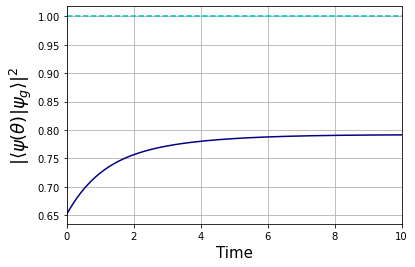

In [85]:
n = 1
colors = plt.cm.jet(np.linspace(0,1,n))

for kkk in range(1):
    plt.plot(time_domain,expt_value[kkk], color = colors[kkk])
plt.plot(time_domain,1.*np.ones(len(time_domain)), ls = "--", color ="c")

plt.ylabel(r"$|\langle \psi(\theta)|\psi_g\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
#plt.legend()
plt.xlim(0,10)
#plt.ylim(0.99,1)

#plt.savefig("Imaginary_time_evolution_fidelity_3qutrits_M=0.1_N=2_comparison.pdf")

No handles with labels found to put in legend.


(0.0, 10.0)

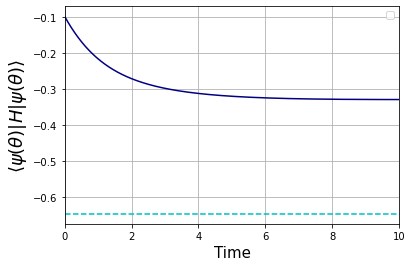

In [86]:
for kkk in range(1):
    plt.plot(time_domain,energyy[kkk], color = colors[kkk])
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="c")

plt.ylabel(r"$\langle \psi(\theta)|H|\psi(\theta)\rangle$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,10)
#plt.ylim(-0.65,-0.63)

#plt.savefig("Imaginary_time_evolution_energy_3qutrits_M=0.1_N=2_comparison.pdf")

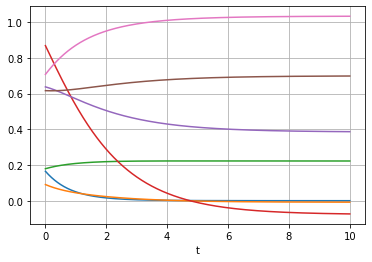

In [40]:
import matplotlib.pyplot as plt
for i in range(coeff*N):
    plt.plot(time_domain, [row[i] for row in Y])
#plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
#plt.xlim(5.9,6.1)
plt.show()

In [43]:
for i in range(coeff*N):
    print(Y[-1][i])

4.838222842295315e-06
-0.00822376007702962
0.22224045415837237
-0.07402449858619298
0.3864191038973874
0.6980257068843853
1.0326600859094566


In [212]:
obs = [[1.,2]]
obs_1 = [[-1.,1]]


obs_map = [
            ["z", obs], 
            ["z", obs_1], 


]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()
observable_matrix_p = observable_matrix
for i in range(L+1):
    observable_matrix_p = (Proj[i]+Proj_0[i])@observable_matrix_p@(Proj[i]+Proj_0[i])
    
observable_matrix = observable_matrix_p



In [214]:
def hamiltonian_evolution(theta):
    return expm(-1j*full_ham_matrix.toarray()*theta)

def hamiltonian_evolution_1(theta):
    return expm(-1j*constrained_full_ham_matrix.toarray()*theta)

In [218]:
for i in range(coeff*N):
    print(Y[0][i])

0.37141536888406607
0.6602899660443315
0.11637371823579168
0.39901353290549235
0.9247979940631299
0.026453178512319396
0.4382807802429473
0.07025615093206115
0.3606296388374573
0.8138966259351307
0.9031720383192907
0.523454217057356
0.9272695715059814
0.9827474226150743
0.2639324508516817
0.41284186279042756
0.8757225556853009
0.523982524132141
0.9490899608210723
0.6202612047452045
0.19801202641088236
0.6716191124543176


(0.0, 10.0)

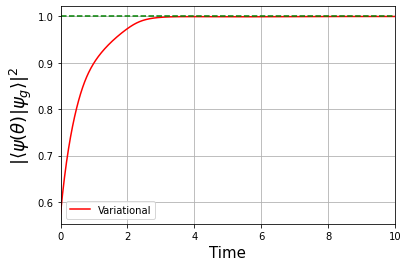

(0.0, 10.0)

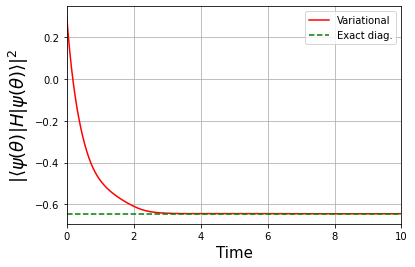

In [220]:
plt.plot(time_domain,energy, color = "red",label = "Variational")
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="g", label = "Exact diag.")

plt.ylabel(r"$|\langle \psi(\theta)|H|\psi(\theta)\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,10)
#plt.ylim(-0.65,-0.63)

#plt.savefig("Imaginary_time_evolution_energy_3qutrits_M=0.1_N=2_1.pdf")

In [221]:
print(expt_value_u[-1])

0.999481430342308


In [124]:
a = np.array([1,2,4])
ind = [1,3,5]
for i in ind:
    a = np.insert(a,i,i)
    print(a)

[1 1 2 4]
[1 1 2 3 4]
[1 1 2 3 4 5]


In [33]:
vec = np.array([1,2,3,4,5])
print(vec[-1]-vec[0])

4
